In [ ]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Extended lists with Nigerian snacks and more moods
moods = ['happy', 'stressed', 'bored', 'sad', 'excited', 'tired', 'anxious', 'content', 'nostalgic', 'hungry']
snacks = [
    # Original snacks
    'fruit', 'chocolate', 'chips', 'popcorn', 'ice cream', 'pretzels',
    'nuts', 'cookies', 'candy', 'yogurt', 'granola bar', 'crackers',
    'veggies', 'cheese', 'dried fruit',
    # Nigerian snacks
    'chin chin', 'kuli kuli', 'plantain chips', 'puff puff', 'akara',
    'coconut candy', 'kokoro', 'dodo ikire', 'roasted groundnuts', 'suya'
]
times_of_day = ['morning', 'afternoon', 'evening', 'midnight']

# Generate dataset
n_samples = 100
data = {
    'mood': np.random.choice(moods, size=n_samples, p=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05]),
    'time_of_day': np.random.choice(times_of_day, size=n_samples),
    'sentiment': np.random.uniform(-1, 1, size=n_samples).round(2),
    'snack': np.random.choice(snacks, size=n_samples)
}

# Create DataFrame
df = pd.DataFrame(data)

# Adjust sentiment based on mood for realism
df.loc[df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'] = df.loc[
    df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'].clip(lower=0.2)
df.loc[df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'] = df.loc[
    df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'].clip(upper=-0.1)
df.loc[df['mood'].isin(['bored', 'hungry']), 'sentiment'] = df.loc[
    df['mood'].isin(['bored', 'hungry']), 'sentiment'].clip(-0.3, 0.3)

# Save to CSV
df.to_csv('snack_data.csv', index=False)

# Preview
print(df.head(10))

        mood time_of_day  sentiment           snack
0        sad     evening      -0.10   coconut candy
1     hungry    midnight      -0.30      dodo ikire
2    anxious     evening      -0.71           fruit
3      tired     morning      -0.10           chips
4   stressed    midnight      -0.10  plantain chips
5   stressed     morning      -0.52            suya
6      happy    midnight       0.34          yogurt
7  nostalgic    midnight       0.52          kokoro
8      tired   afternoon      -0.52           chips
9    anxious     morning      -0.10         cookies


Snack Frequency:
snack
dodo ikire            37
chin chin             35
akara                 34
puff puff             32
kuli kuli             30
coconut candy         28
suya                  25
plantain chips        24
granola bar           22
cookies               21
candy                 21
chocolate             20
cheese                20
veggies               20
roasted groundnuts    16
yogurt                15
fruit                 14
crackers              13
popcorn               13
nuts                  13
pretzels              12
chips                 12
ice cream             12
dried fruit           11
Name: count, dtype: int64

Snack Group Frequency:
snack_group
nigerian_fried     101
healthy_light       91
nigerian_savory     79
sweet_snacks        74
nigerian_sweet      65
savory_snacks       50
nuts_seeds          40
Name: count, dtype: int64

Snack Type Frequency:
snack_type
sweet     217
savory    137
light      91
spicy      55
Name: count, dtype: int64

X shape: (5

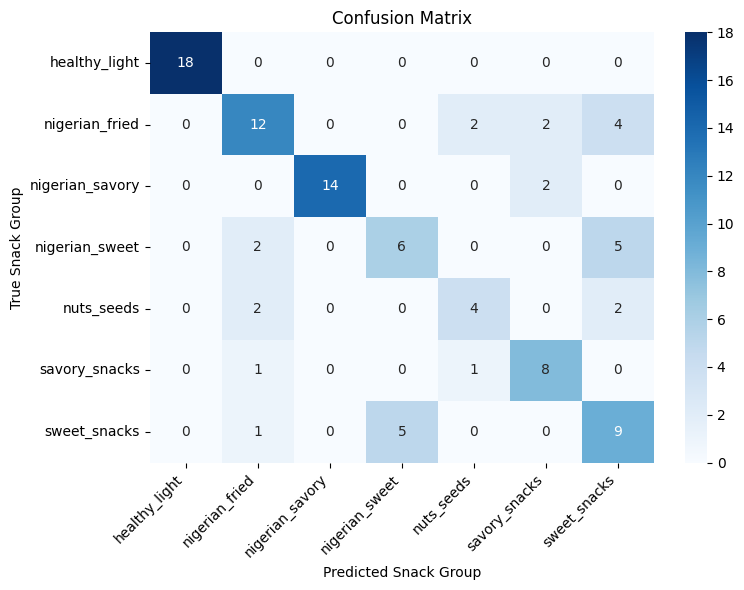


Example Predictions:
You're craving: pretzels (from savory_snacks)!
You're craving: ice cream (from sweet_snacks)!
You're craving: suya (from nigerian_savory)!

Feature Importance:
       Feature  Importance
3   Snack Type    0.613310
0         Mood    0.226857
2    Sentiment    0.114105
1  Time of Day    0.045728


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Step 1: Generate dataset with mood-snack affinities
np.random.seed(42)
moods = ['happy', 'stressed', 'bored', 'sad', 'excited', 'tired', 'anxious', 'content', 'nostalgic', 'hungry']
snacks = [
    'fruit', 'chocolate', 'chips', 'popcorn', 'ice cream', 'pretzels', 'nuts', 'cookies', 'candy',
    'yogurt', 'granola bar', 'crackers', 'veggies', 'cheese', 'dried fruit',
    'chin chin', 'kuli kuli', 'plantain chips', 'puff puff', 'akara', 'coconut candy',
    'kokoro', 'dodo ikire', 'roasted groundnuts', 'suya'
]
times_of_day = ['morning', 'afternoon', 'evening', 'midnight']

# Snack grouping to reduce classes
snack_groups = {
    'nigerian_fried': ['chin chin', 'puff puff', 'akara'],
    'nigerian_savory': ['suya', 'kuli kuli', 'plantain chips'],
    'nigerian_sweet': ['coconut candy', 'dodo ikire'],
    'nuts_seeds': ['nuts', 'roasted groundnuts', 'dried fruit'],
    'sweet_snacks': ['chocolate', 'candy', 'cookies', 'ice cream'],
    'savory_snacks': ['chips', 'popcorn', 'pretzels', 'crackers'],
    'healthy_light': ['fruit', 'yogurt', 'veggies', 'granola bar', 'cheese']
}
snack_to_group = {snack: group for group, snacks in snack_groups.items() for snack in snacks}
group_list = list(snack_groups.keys())

# Mood-snack group affinities (fewer classes, stronger patterns)
mood_group_probs = {
    'happy': {'nigerian_fried': 0.4, 'nigerian_sweet': 0.3, 'sweet_snacks': 0.2, 'healthy_light': 0.1},
    'stressed': {'sweet_snacks': 0.4, 'nigerian_savory': 0.3, 'savory_snacks': 0.2, 'nuts_seeds': 0.1},
    'bored': {'nigerian_savory': 0.4, 'savory_snacks': 0.3, 'nigerian_fried': 0.2, 'healthy_light': 0.1},
    'sad': {'sweet_snacks': 0.4, 'nigerian_sweet': 0.3, 'healthy_light': 0.2, 'nigerian_fried': 0.1},
    'excited': {'nigerian_savory': 0.4, 'nigerian_fried': 0.3, 'sweet_snacks': 0.2, 'nuts_seeds': 0.1},
    'tired': {'healthy_light': 0.4, 'nuts_seeds': 0.3, 'nigerian_sweet': 0.2, 'sweet_snacks': 0.1},
    'anxious': {'savory_snacks': 0.4, 'nigerian_savory': 0.3, 'nuts_seeds': 0.2, 'healthy_light': 0.1},
    'content': {'healthy_light': 0.4, 'nigerian_fried': 0.3, 'nigerian_sweet': 0.2, 'nuts_seeds': 0.1},
    'nostalgic': {'nigerian_sweet': 0.4, 'nigerian_fried': 0.3, 'healthy_light': 0.2, 'sweet_snacks': 0.1},
    'hungry': {'nigerian_savory': 0.4, 'nigerian_fried': 0.3, 'savory_snacks': 0.2, 'nuts_seeds': 0.1}
}

# Generate 500 samples
n_samples = 500
data = {'mood': [], 'time_of_day': [], 'sentiment': [], 'snack': [], 'snack_group': []}

for _ in range(n_samples):
    mood = np.random.choice(moods, p=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
    time = np.random.choice(times_of_day)
    sentiment = round(np.random.uniform(-1, 1), 2)

    # Choose snack group based on mood
    group_probs = [mood_group_probs[mood].get(g, 0.01) for g in group_list]
    group = np.random.choice(group_list, p=group_probs / np.sum(group_probs))
    # Choose specific snack within group
    group_snacks = snack_groups[group]
    snack = np.random.choice(group_snacks)

    data['mood'].append(mood)
    data['time_of_day'].append(time)
    data['sentiment'].append(sentiment)
    data['snack'].append(snack)
    data['snack_group'].append(group)

df = pd.DataFrame(data)

# Adjust sentiment for realism
df.loc[df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'] = df.loc[
    df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'].clip(lower=0.2)
df.loc[df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'] = df.loc[
    df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'].clip(upper=-0.1)
df.loc[df['mood'].isin(['bored', 'hungry']), 'sentiment'] = df.loc[
    df['mood'].isin(['bored', 'hungry']), 'sentiment'].clip(-0.3, 0.3)

# Add snack_type feature
snack_types = {
    'chin chin': 'sweet', 'puff puff': 'sweet', 'akara': 'savory', 'suya': 'spicy',
    'kuli kuli': 'spicy', 'plantain chips': 'savory', 'coconut candy': 'sweet',
    'dodo ikire': 'sweet', 'roasted groundnuts': 'savory', 'fruit': 'light',
    'yogurt': 'light', 'veggies': 'light', 'granola bar': 'light', 'cheese': 'light',
    'chocolate': 'sweet', 'candy': 'sweet', 'cookies': 'sweet', 'ice cream': 'sweet',
    'chips': 'savory', 'popcorn': 'savory', 'pretzels': 'savory', 'crackers': 'savory',
    'nuts': 'savory', 'dried fruit': 'sweet'
}
df['snack_type'] = df['snack'].map(snack_types)

# Check frequencies
print("Snack Frequency:")
print(df['snack'].value_counts())
print("\nSnack Group Frequency:")
print(df['snack_group'].value_counts())
print("\nSnack Type Frequency:")
print(df['snack_type'].value_counts())

# Save dataset
df.to_csv('snack_data.csv', index=False)

# Step 2: Train Random Forest Classifier
# Encode categorical variables
le_mood = LabelEncoder()
le_time = LabelEncoder()
le_snack = LabelEncoder()
le_group = LabelEncoder()
le_type = LabelEncoder()

df['mood_encoded'] = le_mood.fit_transform(df['mood'])
df['time_encoded'] = le_time.fit_transform(df['time_of_day'])
df['snack_encoded'] = le_snack.fit_transform(df['snack'])
df['group_encoded'] = le_group.fit_transform(df['snack_group'])
df['type_encoded'] = le_type.fit_transform(df['snack_type'])

# Features and target (predict snack_group, not individual snack)
X = df[['mood_encoded', 'time_encoded', 'sentiment', 'type_encoded']]
y = df['group_encoded']

# Debug: Check data integrity
print("\nX shape:", X.shape)
print("y shape:", y.shape)
print("Any NaN in X:", X.isna().any().any())
print("Any NaN in y:", y.isna().any())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=8,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_group.classes_))

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_group.classes_, yticklabels=le_group.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Snack Group')
plt.ylabel('True Snack Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Prediction function (predicts group, then picks a snack)
def predict_snack(mood, time_of_day, sentiment, snack_type):
    try:
        mood_enc = le_mood.transform([mood])[0]
        time_enc = le_time.transform([time_of_day])[0]
        type_enc = le_type.transform([snack_type])[0]
        input_data = np.array([[mood_enc, time_enc, sentiment, type_enc]])
        pred = model.predict(input_data)
        group = le_group.inverse_transform(pred)[0]
        snack = np.random.choice(snack_groups[group])
        return f"You're craving: {snack} (from {group})!"
    except ValueError:
        return f"Error: Invalid input. Mood must be one of {list(le_mood.classes_)}, time one of {list(le_time.classes_)}, type one of {list(le_type.classes_)}."

# Example predictions
print("\nExample Predictions:")
print(predict_snack('bored', 'evening', 0.1, 'savory'))
print(predict_snack('happy', 'morning', 0.8, 'sweet'))
print(predict_snack('hungry', 'midnight', -0.2, 'spicy'))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Mood', 'Time of Day', 'Sentiment', 'Snack Type'],
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

Snack Frequency:
snack
coconut candy         45
dodo ikire            43
puff puff             38
akara                 36
chin chin             33
cookies               29
kilishi               28
suya                  28
fruit                 28
chocolate             27
ice cream             25
cheese                23
kuli kuli             22
roasted groundnuts    20
candy                 19
boli                  19
granola bar           16
dried fruit           16
pretzels              16
chips                 14
nuts                  14
kokoro                12
yogurt                12
crackers              11
veggies               10
plantain chips         9
popcorn                7
Name: count, dtype: int64

Snack Group Frequency:
snack_group
nigerian_fried     107
nigerian_savory    106
sweet_snacks       100
healthy_light       89
nigerian_sweet      88
savory_snacks       60
nuts_seeds          50
Name: count, dtype: int64

Snack Type Frequency:
snack_type
sweet     275
savor

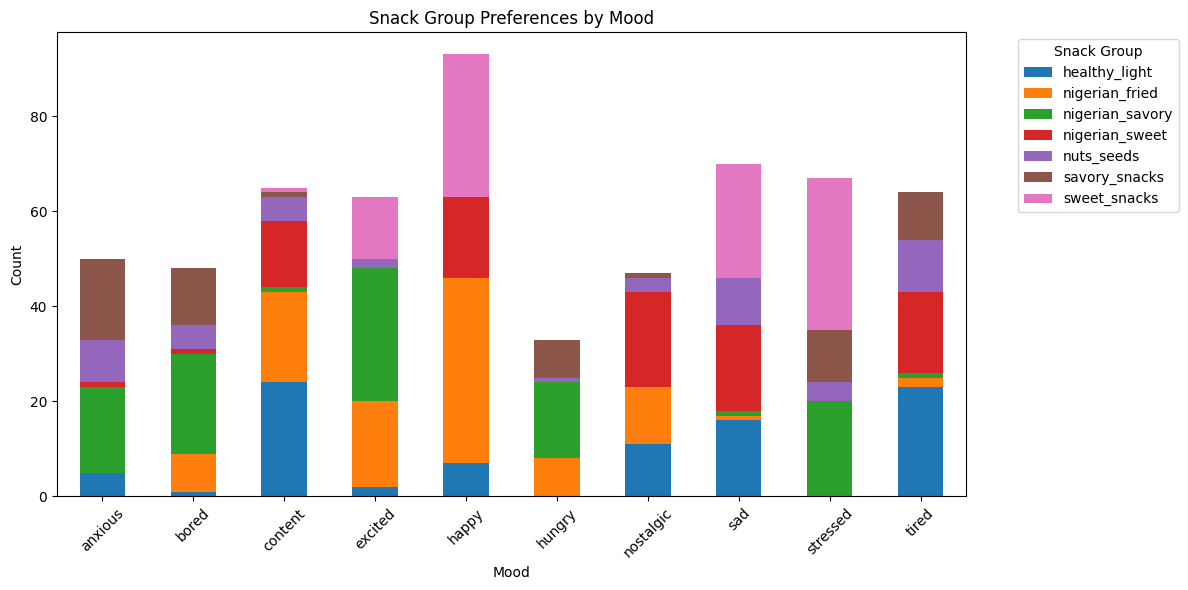


X shape: (600, 4)
y shape: (600,)
Any NaN in X: False
Any NaN in y: False

Test Accuracy: 0.64

Classification Report:
                 precision    recall  f1-score   support

  healthy_light       1.00      1.00      1.00        18
 nigerian_fried       0.52      0.76      0.62        21
nigerian_savory       0.88      0.71      0.79        21
 nigerian_sweet       0.60      0.50      0.55        18
     nuts_seeds       0.25      0.10      0.14        10
  savory_snacks       0.45      0.75      0.56        12
   sweet_snacks       0.60      0.45      0.51        20

       accuracy                           0.64       120
      macro avg       0.61      0.61      0.60       120
   weighted avg       0.65      0.64      0.63       120


Cross-Validation Accuracy: 0.67 (+/- 0.04)


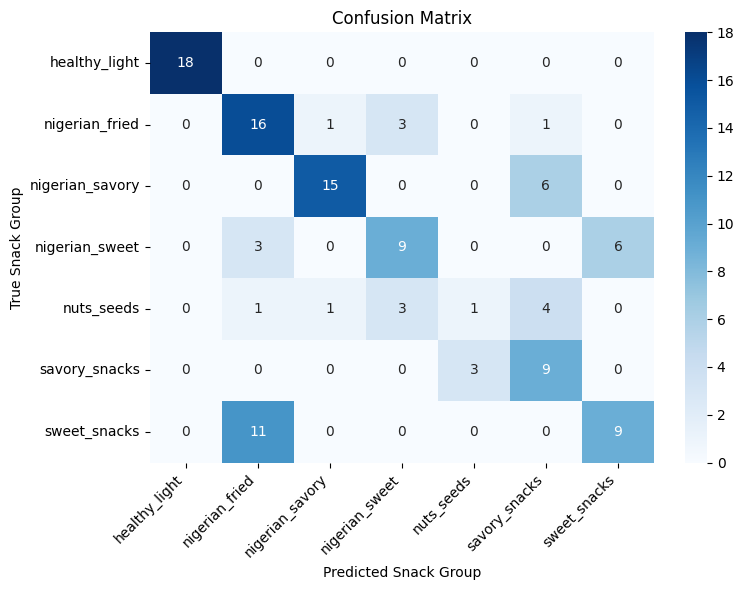


Snack Predictor! Enter your details:
You're craving: plantain chips (from nigerian_savory)!



KeyboardInterrupt: Interrupted by user

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Step 1: Generate dataset with mood-snack affinities
np.random.seed(42)
moods = ['happy', 'stressed', 'bored', 'sad', 'excited', 'tired', 'anxious', 'content', 'nostalgic', 'hungry']
snacks = [
    'fruit', 'chocolate', 'chips', 'popcorn', 'ice cream', 'pretzels', 'nuts', 'cookies', 'candy',
    'yogurt', 'granola bar', 'crackers', 'veggies', 'cheese', 'dried fruit',
    'chin chin', 'kuli kuli', 'plantain chips', 'puff puff', 'akara', 'coconut candy',
    'kokoro', 'dodo ikire', 'roasted groundnuts', 'suya', 'boli', 'kilishi'  # Added boli, kilishi
]
times_of_day = ['morning', 'afternoon', 'evening', 'midnight']

# Refined snack grouping to reduce overlap and emphasize Nigerian snacks
snack_groups = {
    'nigerian_fried': ['chin chin', 'puff puff', 'akara'],
    'nigerian_savory': ['suya', 'kuli kuli', 'plantain chips', 'boli', 'kilishi'],
    'nigerian_sweet': ['coconut candy', 'dodo ikire'],
    'nuts_seeds': ['roasted groundnuts', 'nuts', 'dried fruit'],
    'sweet_snacks': ['chocolate', 'candy', 'cookies', 'ice cream'],
    'savory_snacks': ['chips', 'popcorn', 'pretzels', 'crackers', 'kokoro'],
    'healthy_light': ['fruit', 'yogurt', 'veggies', 'granola bar', 'cheese']
}
snack_to_group = {snack: group for group, snacks in snack_groups.items() for snack in snacks}
group_list = list(snack_groups.keys())

# Mood-snack group affinities (stronger, less overlap)
mood_group_probs = {
    'happy': {'nigerian_fried': 0.4, 'nigerian_sweet': 0.3, 'sweet_snacks': 0.2, 'healthy_light': 0.1},
    'stressed': {'sweet_snacks': 0.4, 'nigerian_savory': 0.3, 'savory_snacks': 0.2, 'nuts_seeds': 0.1},
    'bored': {'nigerian_savory': 0.4, 'savory_snacks': 0.3, 'nigerian_fried': 0.2, 'nuts_seeds': 0.1},
    'sad': {'sweet_snacks': 0.4, 'nigerian_sweet': 0.3, 'healthy_light': 0.2, 'nuts_seeds': 0.1},
    'excited': {'nigerian_savory': 0.4, 'nigerian_fried': 0.3, 'sweet_snacks': 0.2, 'healthy_light': 0.1},
    'tired': {'healthy_light': 0.4, 'nuts_seeds': 0.3, 'nigerian_sweet': 0.2, 'savory_snacks': 0.1},
    'anxious': {'savory_snacks': 0.4, 'nigerian_savory': 0.3, 'nuts_seeds': 0.2, 'healthy_light': 0.1},
    'content': {'healthy_light': 0.4, 'nigerian_fried': 0.3, 'nigerian_sweet': 0.2, 'nuts_seeds': 0.1},
    'nostalgic': {'nigerian_sweet': 0.4, 'nigerian_fried': 0.3, 'healthy_light': 0.2, 'nuts_seeds': 0.1},
    'hungry': {'nigerian_savory': 0.4, 'nigerian_fried': 0.3, 'savory_snacks': 0.2, 'nuts_seeds': 0.1}
}

# Generate 600 samples for better balance
n_samples = 600
data = {'mood': [], 'time_of_day': [], 'sentiment': [], 'snack': [], 'snack_group': []}

for _ in range(n_samples):
    mood = np.random.choice(moods, p=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
    time = np.random.choice(times_of_day)
    sentiment = round(np.random.uniform(-1, 1), 2)

    # Choose snack group based on mood
    group_probs = [mood_group_probs[mood].get(g, 0.01) for g in group_list]
    group = np.random.choice(group_list, p=group_probs / np.sum(group_probs))
    # Choose specific snack within group with slight bias for Nigerian snacks
    group_snacks = snack_groups[group]
    snack_probs = [0.3 if snack in ['chin chin', 'suya', 'puff puff', 'akara', 'kuli kuli', 'boli', 'kilishi'] else 0.2 for snack in group_snacks]
    snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))

    data['mood'].append(mood)
    data['time_of_day'].append(time)
    data['sentiment'].append(sentiment)
    data['snack'].append(snack)
    data['snack_group'].append(group)

df = pd.DataFrame(data)

# Adjust sentiment for realism
df.loc[df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'] = df.loc[
    df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'].clip(lower=0.2)
df.loc[df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'] = df.loc[
    df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'].clip(upper=-0.1)
df.loc[df['mood'].isin(['bored', 'hungry']), 'sentiment'] = df.loc[
    df['mood'].isin(['bored', 'hungry']), 'sentiment'].clip(-0.3, 0.3)

# Add snack_type feature
snack_types = {
    'chin chin': 'sweet', 'puff puff': 'sweet', 'akara': 'savory', 'suya': 'spicy',
    'kuli kuli': 'spicy', 'plantain chips': 'savory', 'coconut candy': 'sweet',
    'dodo ikire': 'sweet', 'roasted groundnuts': 'savory', 'fruit': 'light',
    'yogurt': 'light', 'veggies': 'light', 'granola bar': 'light', 'cheese': 'light',
    'chocolate': 'sweet', 'candy': 'sweet', 'cookies': 'sweet', 'ice cream': 'sweet',
    'chips': 'savory', 'popcorn': 'savory', 'pretzels': 'savory', 'crackers': 'savory',
    'nuts': 'savory', 'dried fruit': 'sweet', 'kokoro': 'savory',
    'boli': 'savory', 'kilishi': 'spicy'
}
df['snack_type'] = df['snack'].map(snack_types)

# Check frequencies
print("Snack Frequency:")
print(df['snack'].value_counts())
print("\nSnack Group Frequency:")
print(df['snack_group'].value_counts())
print("\nSnack Type Frequency:")
print(df['snack_type'].value_counts())

# Visualize mood-snack group trends
plt.figure(figsize=(12, 6))
pd.crosstab(df['mood'], df['snack_group']).plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Snack Group Preferences by Mood')
plt.xlabel('Mood')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Snack Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save dataset
df.to_csv('snack_data.csv', index=False)

# Step 2: Train Random Forest Classifier
# Encode categorical variables
le_mood = LabelEncoder()
le_time = LabelEncoder()
le_snack = LabelEncoder()
le_group = LabelEncoder()
le_type = LabelEncoder()

df['mood_encoded'] = le_mood.fit_transform(df['mood'])
df['time_encoded'] = le_time.fit_transform(df['time_of_day'])
df['snack_encoded'] = le_snack.fit_transform(df['snack'])
df['group_encoded'] = le_group.fit_transform(df['snack_group'])
df['type_encoded'] = le_type.fit_transform(df['snack_type'])

# Features and target (predict snack_group)
X = df[['mood_encoded', 'time_encoded', 'sentiment', 'type_encoded']]
y = df['group_encoded']

# Debug: Check data integrity
print("\nX shape:", X.shape)
print("y shape:", y.shape)
print("Any NaN in X:", X.isna().any().any())
print("Any NaN in y:", y.isna().any())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = RandomForestClassifier(
    n_estimators=200,  # More trees for stability
    max_depth=5,       # Shallower to generalize better
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_group.classes_))

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_group.classes_, yticklabels=le_group.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Snack Group')
plt.ylabel('True Snack Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Interactive prediction function
def predict_snack_interactive():
    print("\nSnack Predictor! Enter your details:")
    while True:
        mood = input("Mood (or 'quit' to exit): ").lower()
        if mood == 'quit':
            break
        if mood not in le_mood.classes_:
            print(f"Invalid mood. Choose from: {list(le_mood.classes_)}")
            continue
        time = input("Time of day (morning, afternoon, evening, midnight): ").lower()
        if time not in le_time.classes_:
            print(f"Invalid time. Choose from: {list(le_time.classes_)}")
            continue
        try:
            sentiment = float(input("Sentiment (-1 to 1, e.g., 0.5 for happy, -0.5 for sad): "))
            if not -1 <= sentiment <= 1:
                print("Sentiment must be between -1 and 1.")
                continue
        except ValueError:
            print("Invalid sentiment. Enter a number (e.g., 0.5).")
            continue
        snack_type = input("Snack type (sweet, savory, spicy, light): ").lower()
        if snack_type not in le_type.classes_:
            print(f"Invalid type. Choose from: {list(le_type.classes_)}")
            continue

        mood_enc = le_mood.transform([mood])[0]
        time_enc = le_time.transform([time])[0]
        type_enc = le_type.transform([snack_type])[0]
        input_data = np.array([[mood_enc, time_enc, sentiment, type_enc]])
        pred = model.predict(input_data)
        group = le_group.inverse_transform(pred)[0]
        # Bias toward Nigerian snacks in group
        group_snacks = snack_groups[group]
        snack_probs = [0.4 if snack in ['chin chin', 'suya', 'puff puff', 'akara', 'kuli kuli', 'boli', 'kilishi'] else 0.2 for snack in group_snacks]
        snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))
        print(f"You're craving: {snack} (from {group})!\n")

# Run interactive predictor
predict_snack_interactive()

# Example predictions (for reference)
print("\nExample Predictions:")
print(predict_snack('bored', 'evening', 0.1, 'savory'))
print(predict_snack('happy', 'morning', 0.8, 'sweet'))
print(predict_snack('hungry', 'midnight', -0.2, 'spicy'))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Mood', 'Time of Day', 'Sentiment', 'Snack Type'],
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

Snack Frequency:
snack
puff puff             50
akara                 48
popcorn               35
candy                 34
kokoro                33
fruit                 31
chocolate             30
cheese                29
chin chin             29
kilishi               26
cookies               26
veggies               22
coconut candy         21
suya                  21
yogurt                19
granola bar           19
ice cream             18
kuli kuli             17
chips                 17
dodo ikire            16
pretzels              16
boli                  14
crackers              11
roasted groundnuts     9
plantain chips         9
Name: count, dtype: int64

Snack Group Frequency:
snack_group
nigerian_sweet     145
nigerian_fried     127
healthy_light      120
savory_snacks      112
nigerian_savory     96
Name: count, dtype: int64

Snack Type Frequency:
snack_type
sweet     224
savory    192
light     120
spicy      64
Name: count, dtype: int64


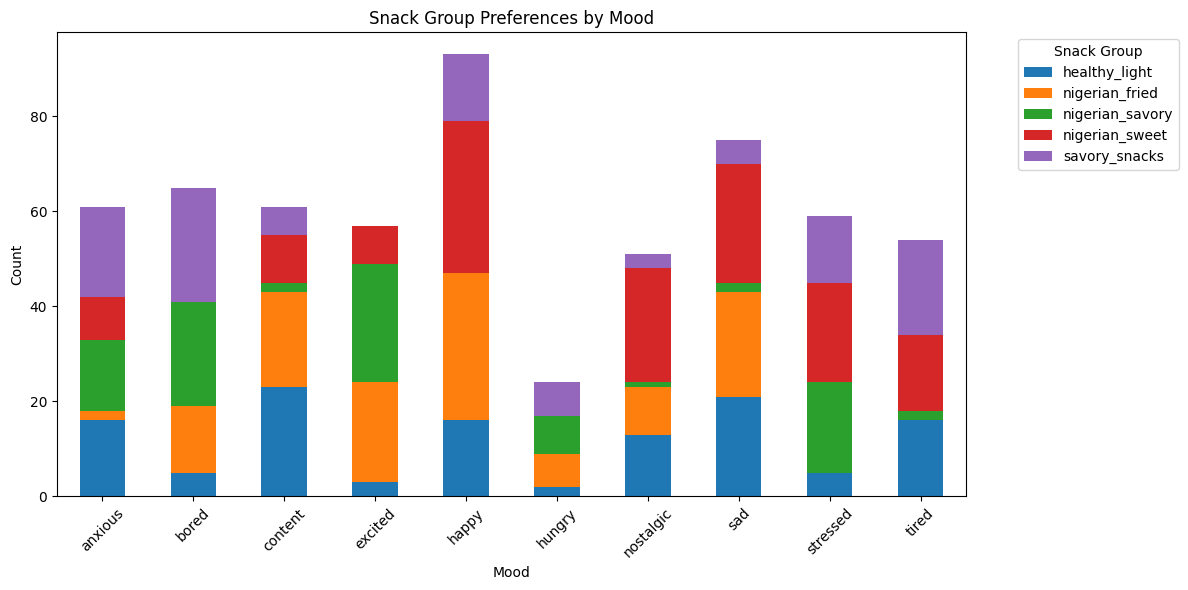


X shape: (600, 5)
y shape: (600,)
Any NaN in X: False
Any NaN in y: False

Test Accuracy: 0.72

Classification Report:
                 precision    recall  f1-score   support

  healthy_light       1.00      1.00      1.00        24
 nigerian_fried       0.41      0.27      0.33        26
nigerian_savory       0.84      0.84      0.84        19
 nigerian_sweet       0.74      0.69      0.71        29
  savory_snacks       0.61      0.91      0.73        22

       accuracy                           0.72       120
      macro avg       0.72      0.74      0.72       120
   weighted avg       0.71      0.72      0.71       120


Cross-Validation Accuracy: 0.74 (+/- 0.06)


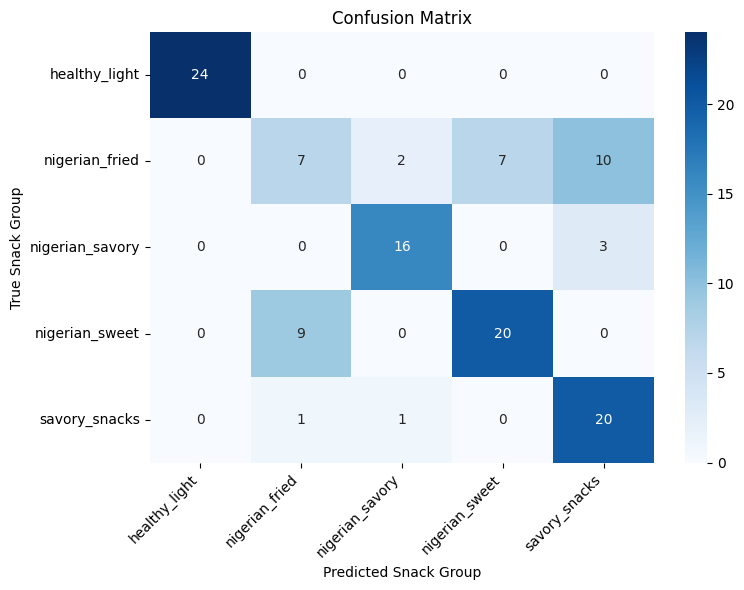


Top Misclassifications (True -> Predicted):
nigerian_fried -> savory_snacks: 10
nigerian_sweet -> nigerian_fried: 9
nigerian_fried -> nigerian_sweet: 7
nigerian_savory -> savory_snacks: 3
nigerian_fried -> nigerian_savory: 2


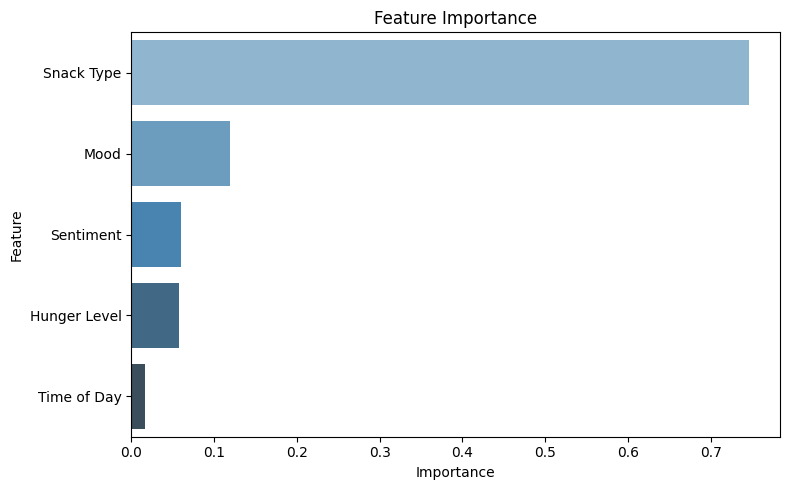


Snack Predictor! Enter your details:
Mood (or 'quit' to exit): Bored
Time of day (morning, afternoon, evening, midnight): afternoon
Snack type (sweet, savory, spicy, light; suggested: savory): sweet
Sentiment (-1 to 1, e.g., 0.5 for happy, -0.5 for sad): 0.5
Hunger level (0 to 1, e.g., 1 for very hungry): 0
You're craving: akara (from nigerian_fried)!



KeyboardInterrupt: Interrupted by user

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Step 1: Generate dataset with mood-snack affinities
np.random.seed(42)
moods = ['happy', 'stressed', 'bored', 'sad', 'excited', 'tired', 'anxious', 'content', 'nostalgic', 'hungry']
snacks = [
    'fruit', 'chocolate', 'chips', 'popcorn', 'ice cream', 'pretzels', 'cookies', 'candy',
    'yogurt', 'granola bar', 'crackers', 'veggies', 'cheese',
    'chin chin', 'kuli kuli', 'plantain chips', 'puff puff', 'akara', 'coconut candy',
    'kokoro', 'dodo ikire', 'roasted groundnuts', 'suya', 'boli', 'kilishi'
]
times_of_day = ['morning', 'afternoon', 'evening', 'midnight']

# Snack groups (5 for simplicity)
snack_groups = {
    'nigerian_fried': ['chin chin', 'puff puff', 'akara'],
    'nigerian_savory': ['suya', 'kuli kuli', 'plantain chips', 'boli', 'kilishi', 'roasted groundnuts'],
    'nigerian_sweet': ['coconut candy', 'dodo ikire', 'chocolate', 'candy', 'cookies', 'ice cream'],
    'savory_snacks': ['chips', 'popcorn', 'pretzels', 'crackers', 'kokoro'],
    'healthy_light': ['fruit', 'yogurt', 'veggies', 'granola bar', 'cheese']
}
snack_to_group = {snack: group for group, snacks in snack_groups.items() for snack in snacks}
group_list = list(snack_groups.keys())

# Mood-snack group affinities
mood_group_probs = {
    'happy': {'nigerian_fried': 0.35, 'nigerian_sweet': 0.3, 'healthy_light': 0.25, 'savory_snacks': 0.1},
    'stressed': {'nigerian_sweet': 0.35, 'nigerian_savory': 0.3, 'savory_snacks': 0.25, 'healthy_light': 0.1},
    'bored': {'nigerian_savory': 0.35, 'savory_snacks': 0.3, 'nigerian_fried': 0.25, 'healthy_light': 0.1},
    'sad': {'nigerian_sweet': 0.35, 'healthy_light': 0.3, 'nigerian_fried': 0.25, 'savory_snacks': 0.1},
    'excited': {'nigerian_savory': 0.35, 'nigerian_fried': 0.3, 'nigerian_sweet': 0.25, 'healthy_light': 0.1},
    'tired': {'healthy_light': 0.35, 'nigerian_sweet': 0.3, 'savory_snacks': 0.25, 'nigerian_savory': 0.1},
    'anxious': {'savory_snacks': 0.35, 'nigerian_savory': 0.3, 'healthy_light': 0.25, 'nigerian_sweet': 0.1},
    'content': {'healthy_light': 0.35, 'nigerian_fried': 0.3, 'nigerian_sweet': 0.25, 'savory_snacks': 0.1},
    'nostalgic': {'nigerian_sweet': 0.35, 'nigerian_fried': 0.3, 'healthy_light': 0.25, 'savory_snacks': 0.1},
    'hungry': {'nigerian_savory': 0.35, 'nigerian_fried': 0.3, 'savory_snacks': 0.25, 'healthy_light': 0.1}
}

# Generate 600 samples
n_samples = 600
data = {'mood': [], 'time_of_day': [], 'hunger_level': [], 'sentiment': [], 'snack': [], 'snack_group': []}

for _ in range(n_samples):
    mood = np.random.choice(moods, p=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
    time = np.random.choice(times_of_day)
    hunger_level = 1.0 if mood == 'hungry' else np.random.uniform(0, 0.8)
    sentiment = round(np.random.uniform(-1, 1), 2)

    # Choose snack group
    group_probs = [mood_group_probs[mood].get(g, 0.01) for g in group_list]
    group = np.random.choice(group_list, p=group_probs / np.sum(group_probs))
    # Choose snack with balanced probs
    group_snacks = snack_groups[group]
    snack_probs = [
        0.35 if snack in ['chin chin', 'suya', 'puff puff', 'akara', 'kuli kuli', 'boli', 'kilishi', 'plantain chips', 'popcorn', 'kokoro']
        else 0.2 for snack in group_snacks
    ]
    snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))

    data['mood'].append(mood)
    data['time_of_day'].append(time)
    data['hunger_level'].append(hunger_level)
    data['sentiment'].append(sentiment)
    data['snack'].append(snack)
    data['snack_group'].append(group)

df = pd.DataFrame(data)

# Adjust sentiment
df.loc[df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'] = df.loc[
    df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'].clip(lower=0.2)
df.loc[df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'] = df.loc[
    df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'].clip(upper=-0.1)
df.loc[df['mood'].isin(['bored', 'hungry']), 'sentiment'] = df.loc[
    df['mood'].isin(['bored', 'hungry']), 'sentiment'].clip(-0.3, 0.3)

# Add snack_type
snack_types = {
    'chin chin': 'sweet', 'puff puff': 'sweet', 'akara': 'savory', 'suya': 'spicy',
    'kuli kuli': 'spicy', 'plantain chips': 'savory', 'coconut candy': 'sweet',
    'dodo ikire': 'sweet', 'roasted groundnuts': 'savory', 'fruit': 'light',
    'yogurt': 'light', 'veggies': 'light', 'granola bar': 'light', 'cheese': 'light',
    'chocolate': 'sweet', 'candy': 'sweet', 'cookies': 'sweet', 'ice cream': 'sweet',
    'chips': 'savory', 'popcorn': 'savory', 'pretzels': 'savory', 'crackers': 'savory',
    'kokoro': 'savory', 'boli': 'savory', 'kilishi': 'spicy'
}
df['snack_type'] = df['snack'].map(snack_types)

# Check frequencies
print("Snack Frequency:")
print(df['snack'].value_counts())
print("\nSnack Group Frequency:")
print(df['snack_group'].value_counts())
print("\nSnack Type Frequency:")
print(df['snack_type'].value_counts())

# Visualize mood-snack group trends
plt.figure(figsize=(12, 6))
pd.crosstab(df['mood'], df['snack_group']).plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Snack Group Preferences by Mood')
plt.xlabel('Mood')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Snack Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save dataset
df.to_csv('snack_data.csv', index=False)

# Step 2: Train Random Forest Classifier
# Encode categorical variables
le_mood = LabelEncoder()
le_time = LabelEncoder()
le_type = LabelEncoder()
le_group = LabelEncoder()

df['mood_encoded'] = le_mood.fit_transform(df['mood'])
df['time_encoded'] = le_time.fit_transform(df['time_of_day'])
df['type_encoded'] = le_type.fit_transform(df['snack_type'])
df['group_encoded'] = le_group.fit_transform(df['snack_group'])

# Features and target
X = df[['mood_encoded', 'time_encoded', 'hunger_level', 'sentiment', 'type_encoded']]
y = df['group_encoded']

# Debug
print("\nX shape:", X.shape)
print("y shape:", y.shape)
print("Any NaN in X:", X.isna().any().any())
print("Any NaN in y:", y.isna().any())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_group.classes_))

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_group.classes_, yticklabels=le_group.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Snack Group')
plt.ylabel('True Snack Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top misclassifications
cm_df = pd.DataFrame(cm, index=le_group.classes_, columns=le_group.classes_)
misclass = cm_df.where(~np.eye(len(cm_df), dtype=bool)).stack().sort_values(ascending=False).head(5)
print("\nTop Misclassifications (True -> Predicted):")
for (true, pred), count in misclass.items():
    if count > 0:
        print(f"{true} -> {pred}: {int(count)}")

# Feature importance plot
feature_importance = pd.DataFrame({
    'Feature': ['Mood', 'Time of Day', 'Hunger Level', 'Sentiment', 'Snack Type'],
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='Blues_d')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Interactive prediction function
def predict_snack_interactive():
    print("\nSnack Predictor! Enter your details:")
    while True:
        mood = input("Mood (or 'quit' to exit): ").lower()
        if mood == 'quit':
            break
        if mood not in le_mood.classes_:
            print(f"Invalid mood. Choose from: {list(le_mood.classes_)}")
            continue
        time = input("Time of day (morning, afternoon, evening, midnight): ").lower()
        if time not in le_time.classes_:
            print(f"Invalid time. Choose from: {list(le_time.classes_)}")
            continue
        suggested_type = 'spicy' if mood == 'hungry' else 'sweet' if mood in ['happy', 'nostalgic'] else 'savory' if mood in ['bored', 'excited'] else 'light'
        snack_type = input(f"Snack type (sweet, savory, spicy, light; suggested: {suggested_type}): ").lower() or suggested_type
        if snack_type not in le_type.classes_:
            print(f"Invalid type. Choose from: {list(le_type.classes_)}")
            continue
        try:
            sentiment = float(input("Sentiment (-1 to 1, e.g., 0.5 for happy, -0.5 for sad): "))
            if not -1 <= sentiment <= 1:
                print("Sentiment must be between -1 and 1.")
                continue
        except ValueError:
            print("Invalid sentiment. Enter a number (e.g., 0.5).")
            continue
        try:
            hunger_level = float(input("Hunger level (0 to 1, e.g., 1 for very hungry): "))
            if not 0 <= hunger_level <= 1:
                print("Hunger level must be between 0 and 1.")
                continue
        except ValueError:
            print("Invalid hunger level. Enter a number (e.g., 1).")
            continue

        mood_enc = le_mood.transform([mood])[0]
        time_enc = le_time.transform([time])[0]
        type_enc = le_type.transform([snack_type])[0]
        input_data = np.array([[mood_enc, time_enc, hunger_level, sentiment, type_enc]])
        pred = model.predict(input_data)
        group = le_group.inverse_transform(pred)[0]
        group_snacks = snack_groups[group]
        snack_probs = [0.4 if snack in ['chin chin', 'suya', 'puff puff', 'akara', 'kuli kuli', 'boli', 'kilishi', 'plantain chips', 'popcorn', 'kokoro']
                       else 0.2 for snack in group_snacks]
        snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))
        print(f"You're craving: {snack} (from {group})!\n")

# Run interactive predictor
predict_snack_interactive()

# Example predictions
def predict_snack(mood, time_of_day, hunger_level, sentiment, snack_type):
    try:
        mood_enc = le_mood.transform([mood])[0]
        time_enc = le_time.transform([time_of_day])[0]
        type_enc = le_type.transform([snack_type])[0]
        input_data = np.array([[mood_enc, time_enc, hunger_level, sentiment, type_enc]])
        pred = model.predict(input_data)
        group = le_group.inverse_transform(pred)[0]
        group_snacks = snack_groups[group]
        snack_probs = [0.4 if snack in ['chin chin', 'suya', 'puff puff', 'akara', 'kuli kuli', 'boli', 'kilishi', 'plantain chips', 'popcorn', 'kokoro']
                       else 0.2 for snack in group_snacks]
        snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))
        return f"You're craving: {snack} (from {group})!"
    except ValueError:
        return f"Error: Invalid input. Mood: {list(le_mood.classes_)}, time: {list(le_time.classes_)}, type: {list(le_type.classes_)}."

print("\nExample Predictions:")
print(predict_snack('bored', 'evening', 0.5, 0.1, 'savory'))
print(predict_snack('happy', 'morning', 0.3, 0.8, 'sweet'))
print(predict_snack('hungry', 'midnight', 1.0, -0.2, 'spicy'))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Mood', 'Time of Day', 'Hunger Level', 'Sentiment', 'Snack Type'],
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

Snack Frequency:
snack
akara                 100
puff puff              97
chin chin              75
chocolate              66
kokoro                 62
fruit                  62
coconut candy          58
dodo ikire             58
popcorn                56
candy                  52
yogurt                 46
ice cream              45
cheese                 42
cookies                41
veggies                39
crackers               38
granola bar            34
pretzels               34
chips                  32
kilishi                30
kuli kuli              29
plantain chips         29
suya                   27
boli                   26
roasted groundnuts     22
Name: count, dtype: int64

Snack Group Frequency:
snack_group
nigerian_sweet     320
nigerian_fried     272
healthy_light      223
savory_snacks      222
nigerian_savory    163
Name: count, dtype: int64

Snack Type Frequency:
snack_type
sweet     492
savory    399
light     223
spicy      86
Name: count, dtype: int64

Snack T

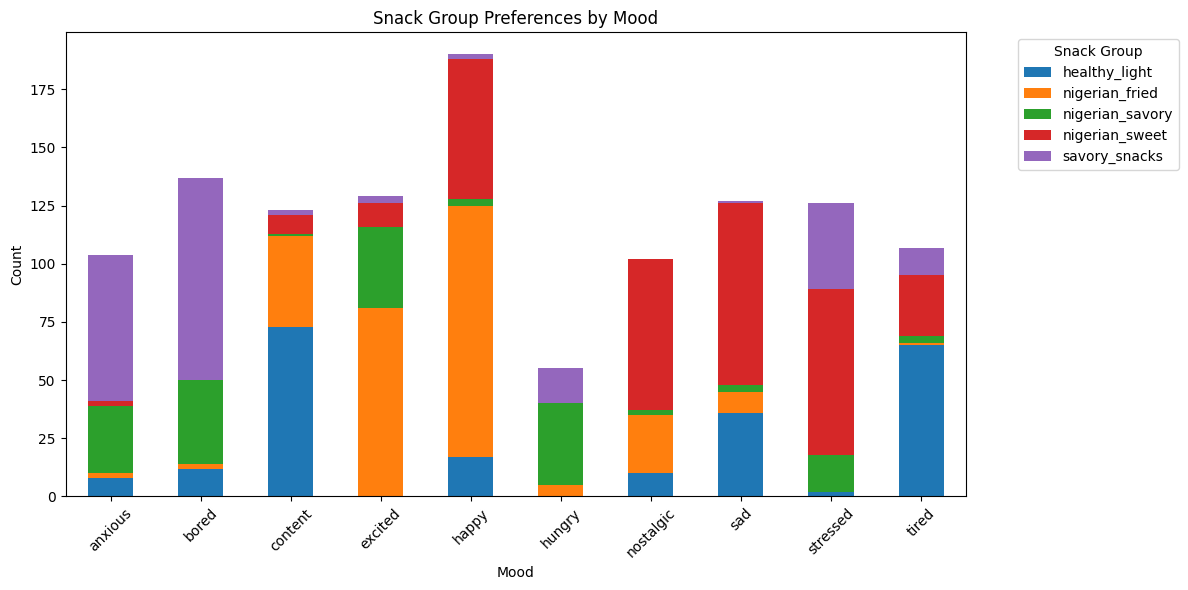


X shape: (1200, 6)
y shape: (1200,)
Any NaN in X: False
Any NaN in y: False
Best Parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 300}

Test Accuracy: 0.90

Classification Report:
                 precision    recall  f1-score   support

  healthy_light       1.00      1.00      1.00        45
 nigerian_fried       0.82      0.93      0.87        54
nigerian_savory       0.92      0.67      0.77        33
 nigerian_sweet       0.95      0.86      0.90        64
  savory_snacks       0.83      0.98      0.90        44

       accuracy                           0.90       240
      macro avg       0.90      0.89      0.89       240
   weighted avg       0.90      0.90      0.89       240


Cross-Validation Accuracy: 0.88 (+/- 0.05)


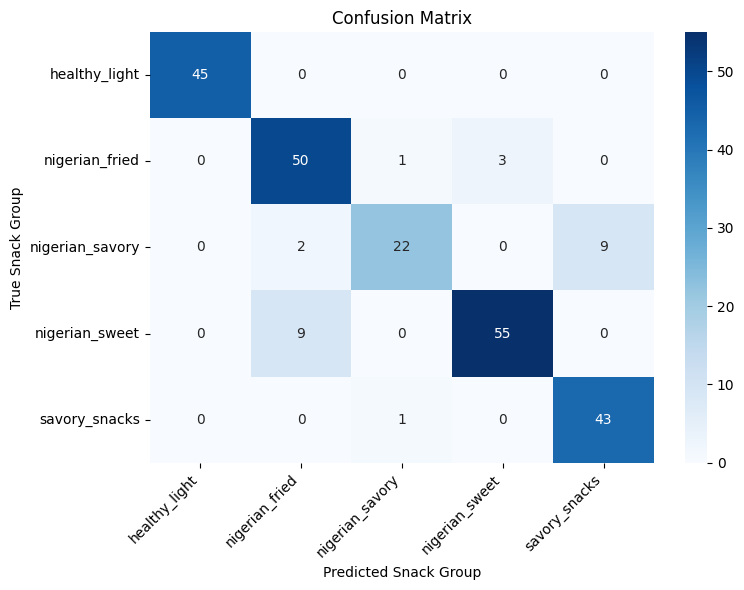


Top Misclassifications (True -> Predicted):
nigerian_sweet -> nigerian_fried: 9
nigerian_savory -> savory_snacks: 9
nigerian_fried -> nigerian_sweet: 3
nigerian_savory -> nigerian_fried: 2
savory_snacks -> nigerian_savory: 1


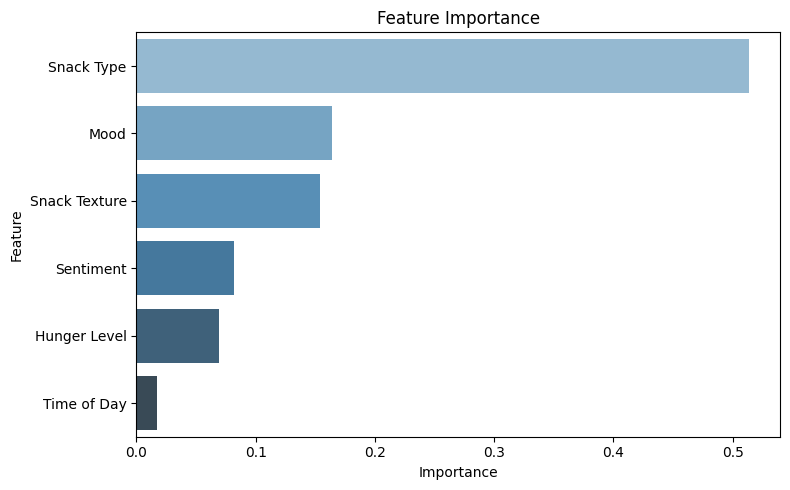


Snack Predictor! Enter your details:
Mood (or 'quit' to exit): bored
Time of day (morning, afternoon, evening, midnight): afternoon
Snack type (sweet, savory, spicy, light; suggested: savory): spicy
Sentiment (-1 to 1, e.g., 0.5 for happy, -0.5 for sad): 0.5
Hunger level (0 to 1, e.g., 1 for very hungry): 1
You're craving: suya (from nigerian_savory)!

Mood (or 'quit' to exit): happy
Time of day (morning, afternoon, evening, midnight): night
Invalid time. Choose from: [np.str_('afternoon'), np.str_('evening'), np.str_('midnight'), np.str_('morning')]
Mood (or 'quit' to exit): evening
Invalid mood. Choose from: [np.str_('anxious'), np.str_('bored'), np.str_('content'), np.str_('excited'), np.str_('happy'), np.str_('hungry'), np.str_('nostalgic'), np.str_('sad'), np.str_('stressed'), np.str_('tired')]
Mood (or 'quit' to exit): happy
Time of day (morning, afternoon, evening, midnight): evening
Snack type (sweet, savory, spicy, light; suggested: sweet): spicy
Sentiment (-1 to 1, e.g., 0.5

KeyboardInterrupt: Interrupted by user

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Step 1: Generate dataset with mood-snack affinities
np.random.seed(42)
moods = ['happy', 'stressed', 'bored', 'sad', 'excited', 'tired', 'anxious', 'content', 'nostalgic', 'hungry']
snacks = [
    'fruit', 'chocolate', 'chips', 'popcorn', 'ice cream', 'pretzels', 'cookies', 'candy',
    'yogurt', 'granola bar', 'crackers', 'veggies', 'cheese',
    'chin chin', 'kuli kuli', 'plantain chips', 'puff puff', 'akara', 'coconut candy',
    'kokoro', 'dodo ikire', 'roasted groundnuts', 'suya', 'boli', 'kilishi'
]
times_of_day = ['morning', 'afternoon', 'evening', 'midnight']

# Snack groups
snack_groups = {
    'nigerian_fried': ['chin chin', 'puff puff', 'akara'],
    'nigerian_savory': ['suya', 'kuli kuli', 'plantain chips', 'boli', 'kilishi', 'roasted groundnuts'],
    'nigerian_sweet': ['coconut candy', 'dodo ikire', 'chocolate', 'candy', 'cookies', 'ice cream'],
    'savory_snacks': ['chips', 'popcorn', 'pretzels', 'crackers', 'kokoro'],
    'healthy_light': ['fruit', 'yogurt', 'veggies', 'granola bar', 'cheese']
}
snack_to_group = {snack: group for group, snacks in snack_groups.items() for snack in snacks}
group_list = list(snack_groups.keys())

# Stricter mood-snack group affinities
mood_group_probs = {
    'happy': {'nigerian_fried': 0.6, 'nigerian_sweet': 0.3, 'healthy_light': 0.1},
    'stressed': {'nigerian_sweet': 0.6, 'savory_snacks': 0.3, 'nigerian_savory': 0.1},
    'bored': {'savory_snacks': 0.6, 'nigerian_savory': 0.3, 'healthy_light': 0.1},
    'sad': {'nigerian_sweet': 0.6, 'healthy_light': 0.3, 'nigerian_fried': 0.1},
    'excited': {'nigerian_fried': 0.6, 'nigerian_savory': 0.3, 'nigerian_sweet': 0.1},
    'tired': {'healthy_light': 0.6, 'nigerian_sweet': 0.3, 'savory_snacks': 0.1},
    'anxious': {'savory_snacks': 0.6, 'nigerian_savory': 0.3, 'healthy_light': 0.1},
    'content': {'healthy_light': 0.6, 'nigerian_fried': 0.3, 'nigerian_sweet': 0.1},
    'nostalgic': {'nigerian_sweet': 0.6, 'nigerian_fried': 0.3, 'healthy_light': 0.1},
    'hungry': {'nigerian_savory': 0.6, 'savory_snacks': 0.3, 'nigerian_fried': 0.1}
}

# Generate 1200 samples
n_samples = 1200
data = {'mood': [], 'time_of_day': [], 'hunger_level': [], 'sentiment': [], 'snack': [], 'snack_group': []}

for _ in range(n_samples):
    mood = np.random.choice(moods, p=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
    time = np.random.choice(times_of_day)
    hunger_level = 1.0 if mood == 'hungry' else np.random.uniform(0, 0.8)
    sentiment = round(np.random.uniform(-1, 1), 2)

    group_probs = [mood_group_probs[mood].get(g, 0.01) for g in group_list]
    group = np.random.choice(group_list, p=group_probs / np.sum(group_probs))
    group_snacks = snack_groups[group]
    snack_probs = [
        0.35 if snack in ['chin chin', 'suya', 'puff puff', 'akara', 'kuli kuli', 'boli', 'kilishi', 'plantain chips', 'popcorn', 'kokoro', 'roasted groundnuts']
        else 0.2 for snack in group_snacks
    ]
    snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))

    data['mood'].append(mood)
    data['time_of_day'].append(time)
    data['hunger_level'].append(hunger_level)
    data['sentiment'].append(sentiment)
    data['snack'].append(snack)
    data['snack_group'].append(group)

df = pd.DataFrame(data)

# Adjust sentiment
df.loc[df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'] = df.loc[
    df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'].clip(lower=0.2)
df.loc[df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'] = df.loc[
    df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'].clip(upper=-0.1)
df.loc[df['mood'].isin(['bored', 'hungry']), 'sentiment'] = df.loc[
    df['mood'].isin(['bored', 'hungry']), 'sentiment'].clip(-0.3, 0.3)

# Add snack_type and snack_texture
snack_types = {
    'chin chin': 'sweet', 'puff puff': 'sweet', 'akara': 'savory', 'suya': 'spicy',
    'kuli kuli': 'spicy', 'plantain chips': 'savory', 'coconut candy': 'sweet',
    'dodo ikire': 'sweet', 'roasted groundnuts': 'savory', 'fruit': 'light',
    'yogurt': 'light', 'veggies': 'light', 'granola bar': 'light', 'cheese': 'light',
    'chocolate': 'sweet', 'candy': 'sweet', 'cookies': 'sweet', 'ice cream': 'sweet',
    'chips': 'savory', 'popcorn': 'savory', 'pretzels': 'savory', 'crackers': 'savory',
    'kokoro': 'savory', 'boli': 'savory', 'kilishi': 'spicy'
}
snack_textures = {
    'chin chin': 'crisp', 'puff puff': 'soft', 'akara': 'soft', 'suya': 'chewy',
    'kuli kuli': 'crisp', 'plantain chips': 'crisp', 'coconut candy': 'chewy',
    'dodo ikire': 'soft', 'roasted groundnuts': 'crisp', 'fruit': 'soft',
    'yogurt': 'soft', 'veggies': 'crisp', 'granola bar': 'crisp', 'cheese': 'soft',
    'chocolate': 'soft', 'candy': 'chewy', 'cookies': 'crisp', 'ice cream': 'soft',
    'chips': 'crisp', 'popcorn': 'crisp', 'pretzels': 'crisp', 'crackers': 'crisp',
    'kokoro': 'crisp', 'boli': 'soft', 'kilishi': 'chewy'
}
df['snack_type'] = df['snack'].map(snack_types)
df['snack_texture'] = df['snack'].map(snack_textures)

# Check frequencies
print("Snack Frequency:")
print(df['snack'].value_counts())
print("\nSnack Group Frequency:")
print(df['snack_group'].value_counts())
print("\nSnack Type Frequency:")
print(df['snack_type'].value_counts())
print("\nSnack Texture Frequency:")
print(df['snack_texture'].value_counts())

# Visualize mood-snack group trends
plt.figure(figsize=(12, 6))
pd.crosstab(df['mood'], df['snack_group']).plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Snack Group Preferences by Mood')
plt.xlabel('Mood')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Snack Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save dataset
df.to_csv('snack_data.csv', index=False)

# Step 2: Train Random Forest Classifier
le_mood = LabelEncoder()
le_time = LabelEncoder()
le_type = LabelEncoder()
le_texture = LabelEncoder()
le_group = LabelEncoder()

df['mood_encoded'] = le_mood.fit_transform(df['mood'])
df['time_encoded'] = le_time.fit_transform(df['time_of_day'])
df['type_encoded'] = le_type.fit_transform(df['snack_type'])
df['texture_encoded'] = le_texture.fit_transform(df['snack_texture'])
df['group_encoded'] = le_group.fit_transform(df['snack_group'])

X = df[['mood_encoded', 'time_encoded', 'hunger_level', 'sentiment', 'type_encoded', 'texture_encoded']]
y = df['group_encoded']

print("\nX shape:", X.shape)
print("y shape:", y.shape)
print("Any NaN in X:", X.isna().any().any())
print("Any NaN in y:", y.isna().any())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [5, 10]
}
model = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_group.classes_))

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_group.classes_, yticklabels=le_group.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Snack Group')
plt.ylabel('True Snack Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

cm_df = pd.DataFrame(cm, index=le_group.classes_, columns=le_group.classes_)
misclass = cm_df.where(~np.eye(len(cm_df), dtype=bool)).stack().sort_values(ascending=False).head(5)
print("\nTop Misclassifications (True -> Predicted):")
for (true, pred), count in misclass.items():
    if count > 0:
        print(f"{true} -> {pred}: {int(count)}")

feature_importance = pd.DataFrame({
    'Feature': ['Mood', 'Time of Day', 'Hunger Level', 'Sentiment', 'Snack Type', 'Snack Texture'],
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='Blues_d')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Fixed interactive prediction function
def predict_snack_interactive():
    print("\nSnack Predictor! Enter your details:")
    while True:
        mood = input("Mood (or 'quit' to exit): ").lower()
        if mood == 'quit':
            break
        if mood not in le_mood.classes_:
            print(f"Invalid mood. Choose from: {list(le_mood.classes_)}")
            continue
        time = input("Time of day (morning, afternoon, evening, midnight): ").lower()
        if time not in le_time.classes_:
            print(f"Invalid time. Choose from: {list(le_time.classes_)}")
            continue
        suggested_type = 'spicy' if mood == 'hungry' else 'sweet' if mood in ['happy', 'nostalgic'] else 'savory' if mood in ['bored', 'excited'] else 'light'
        snack_type = input(f"Snack type (sweet, savory, spicy, light; suggested: {suggested_type}): ").lower() or suggested_type
        if snack_type not in le_type.classes_:
            print(f"Invalid type. Choose from: {list(le_type.classes_)}")
            continue
        try:
            sentiment = float(input("Sentiment (-1 to 1, e.g., 0.5 for happy, -0.5 for sad): "))
            if not -1 <= sentiment <= 1:
                print("Sentiment must be between -1 and 1.")
                continue
        except ValueError:
            print("Invalid sentiment. Enter a number (e.g., 0.5).")
            continue
        try:
            hunger_level = float(input("Hunger level (0 to 1, e.g., 1 for very hungry): "))
            if not 0 <= hunger_level <= 1:
                print("Hunger level must be between 0 and 1.")
                continue
        except ValueError:
            print("Invalid hunger level. Enter a number (e.g., 1).")
            continue

        mood_enc = le_mood.transform([mood])[0]
        time_enc = le_time.transform([time])[0]
        type_enc = le_type.transform([snack_type])[0]
        # Map snack_type to a representative texture (simplified)
        type_to_texture = {'sweet': 'soft', 'savory': 'crisp', 'spicy': 'chewy', 'light': 'soft'}  # Default mappings
        texture = type_to_texture[snack_type]
        texture_enc = le_texture.transform([texture])[0]
        input_data = np.array([[mood_enc, time_enc, hunger_level, sentiment, type_enc, texture_enc]])
        pred = best_model.predict(input_data)
        group = le_group.inverse_transform(pred)[0]
        group_snacks = snack_groups[group]
        snack_probs = [0.4 if snack in ['chin chin', 'suya', 'puff puff', 'akara', 'kuli kuli', 'boli', 'kilishi', 'plantain chips', 'popcorn', 'kokoro', 'roasted groundnuts']
                       else 0.2 for snack in group_snacks]
        snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))
        print(f"You're craving: {snack} (from {group})!\n")

# Run interactive predictor
predict_snack_interactive()

# Example predictions
def predict_snack(mood, time_of_day, hunger_level, sentiment, snack_type):
    try:
        mood_enc = le_mood.transform([mood])[0]
        time_enc = le_time.transform([time_of_day])[0]
        type_enc = le_type.transform([snack_type])[0]
        type_to_texture = {'sweet': 'soft', 'savory': 'crisp', 'spicy': 'chewy', 'light': 'soft'}
        texture_enc = le_texture.transform([type_to_texture[snack_type]])[0]
        input_data = np.array([[mood_enc, time_enc,	hunger_level, sentiment, type_enc, texture_enc]])
        pred = best_model.predict(input_data)
        group = le_group.inverse_transform(pred)[0]
        group_snacks = snack_groups[group]
        snack_probs = [0.4 if snack in ['chin chin', 'suya', 'puff puff', 'akara', 'kuli kuli', 'boli', 'kilishi', 'plantain chips', 'popcorn', 'kokoro', 'roasted groundnuts']
                       else 0.2 for snack in group_snacks]
        snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))
        return f"You're craving: {snack} (from {group})!"
    except ValueError:
        return f"Error: Invalid input. Mood: {list(le_mood.classes_)}, time: {list(le_time.classes_)}, type: {list(le_type.classes_)}."

print("\nExample Predictions:")
print(predict_snack('bored', 'evening', 0.5, 0.1, 'savory'))
print(predict_snack('happy', 'morning', 0.3, 0.8, 'sweet'))
print(predict_snack('hungry', 'midnight', 1.0, -0.2, 'spicy'))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Mood', 'Time of Day', 'Hunger Level', 'Sentiment', 'Snack Type', 'Snack Texture'],
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

Snack Frequency:
snack
akara                 150
puff puff             138
chin chin             123
popcorn                98
kokoro                 95
coconut candy          89
chocolate              85
dodo ikire             84
candy                  83
fruit                  78
cheese                 69
ice cream              68
yogurt                 68
cookies                67
granola bar            65
veggies                65
pretzels               56
crackers               54
chips                  53
suya                   44
plantain chips         43
boli                   37
roasted groundnuts     35
kuli kuli              28
kilishi                25
Name: count, dtype: int64

Snack Group Frequency:
snack_group
nigerian_sweet     476
nigerian_fried     411
savory_snacks      356
healthy_light      345
nigerian_savory    212
Name: count, dtype: int64

Snack Type Frequency:
snack_type
sweet     737
savory    621
light     345
spicy      97
Name: count, dtype: int64

Snack T

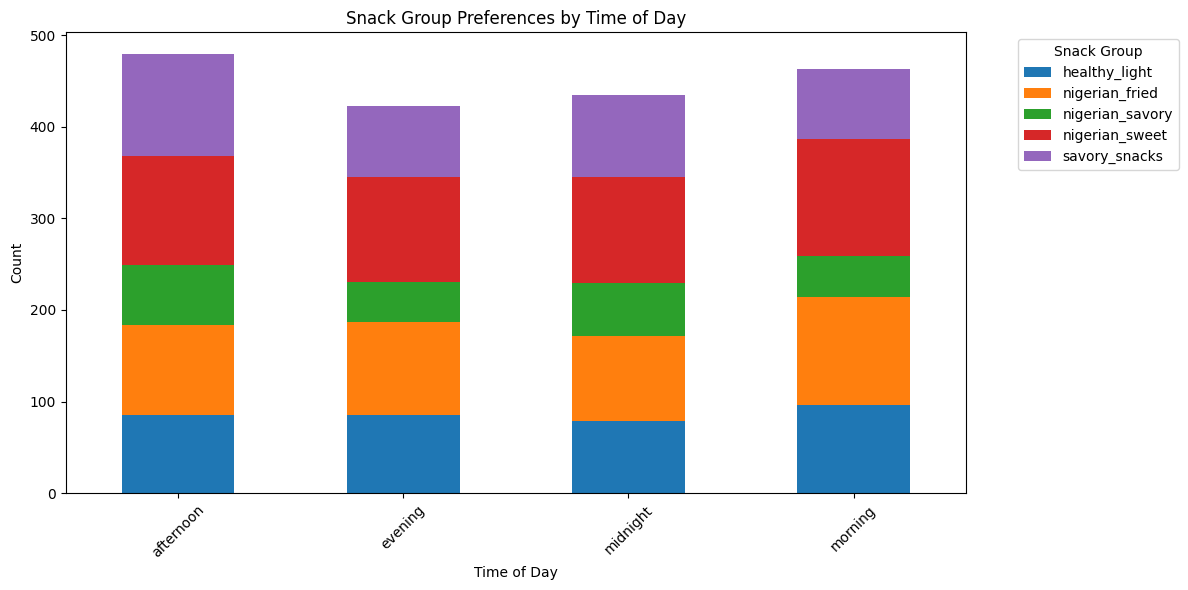


X shape: (1800, 6)
y shape: (1800,)
Any NaN in X: False
Any NaN in y: False
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}

Test Accuracy: 0.92

Classification Report:
                 precision    recall  f1-score   support

  healthy_light       1.00      1.00      1.00        69
 nigerian_fried       0.86      0.94      0.90        82
nigerian_savory       0.86      0.86      0.86        43
 nigerian_sweet       0.96      0.86      0.91        95
  savory_snacks       0.92      0.94      0.93        71

       accuracy                           0.92       360
      macro avg       0.92      0.92      0.92       360
   weighted avg       0.92      0.92      0.92       360


Cross-Validation Accuracy: 0.91 (+/- 0.01)


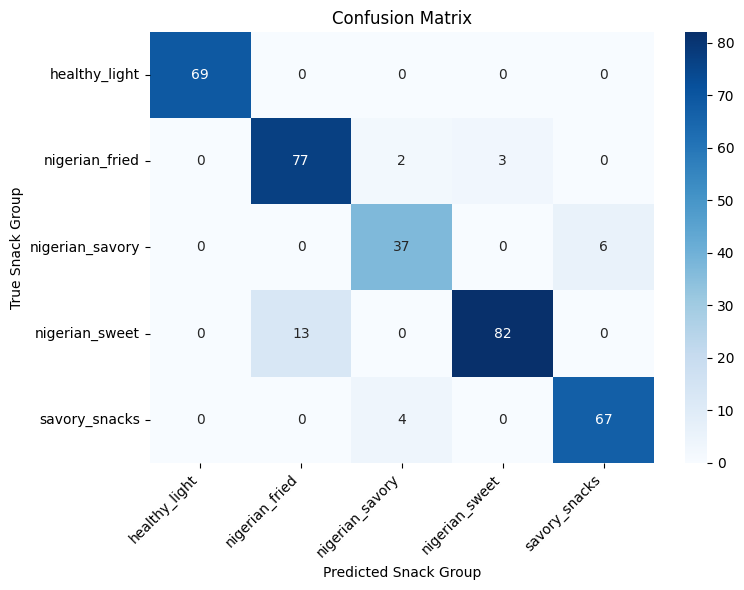


Top Misclassifications (True -> Predicted):
nigerian_sweet -> nigerian_fried: 13
nigerian_savory -> savory_snacks: 6
savory_snacks -> nigerian_savory: 4
nigerian_fried -> nigerian_sweet: 3
nigerian_fried -> nigerian_savory: 2


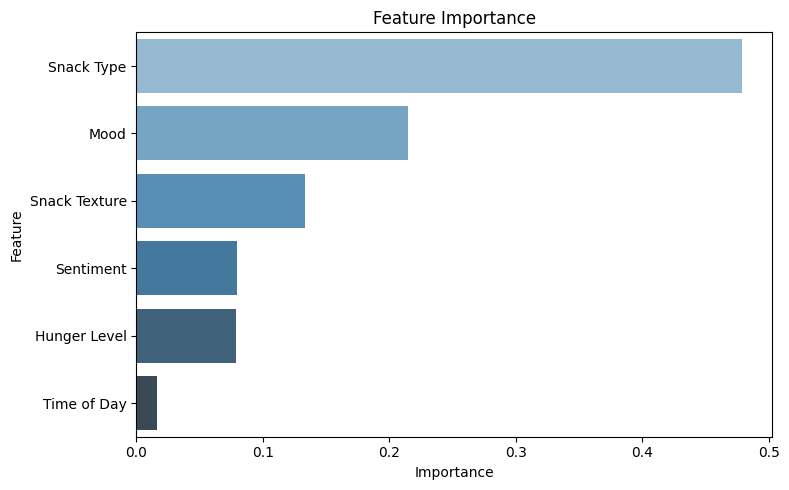


Snack Predictor! Enter your details:


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Step 1: Generate dataset with mood-snack affinities
np.random.seed(42)
moods = ['happy', 'stressed', 'bored', 'sad', 'excited', 'tired', 'anxious', 'content', 'nostalgic', 'hungry']
snacks = [
    'fruit', 'chocolate', 'chips', 'popcorn', 'ice cream', 'pretzels', 'cookies', 'candy',
    'yogurt', 'granola bar', 'crackers', 'veggies', 'cheese',
    'chin chin', 'kuli kuli', 'plantain chips', 'puff puff', 'akara', 'coconut candy',
    'kokoro', 'dodo ikire', 'roasted groundnuts', 'suya', 'boli', 'kilishi'
]
times_of_day = ['morning', 'afternoon', 'evening', 'midnight']

# Snack groups
snack_groups = {
    'nigerian_fried': ['chin chin', 'puff puff', 'akara'],
    'nigerian_savory': ['suya', 'kuli kuli', 'plantain chips', 'boli', 'kilishi', 'roasted groundnuts'],
    'nigerian_sweet': ['coconut candy', 'dodo ikire', 'chocolate', 'candy', 'cookies', 'ice cream'],
    'savory_snacks': ['chips', 'popcorn', 'pretzels', 'crackers', 'kokoro'],
    'healthy_light': ['fruit', 'yogurt', 'veggies', 'granola bar', 'cheese']
}
snack_to_group = {snack: group for group, snacks in snack_groups.items() for snack in snacks}
group_list = list(snack_groups.keys())

# Stricter mood-time-snack group affinities
mood_time_group_probs = {
    'happy': {
        'morning': {'nigerian_fried': 0.7, 'nigerian_sweet': 0.2, 'healthy_light': 0.1},
        'afternoon': {'nigerian_fried': 0.7, 'nigerian_sweet': 0.2, 'healthy_light': 0.1},
        'evening': {'nigerian_fried': 0.7, 'nigerian_sweet': 0.2, 'healthy_light': 0.1},
        'midnight': {'nigerian_fried': 0.7, 'nigerian_sweet': 0.2, 'healthy_light': 0.1}
    },
    'stressed': {
        'morning': {'nigerian_sweet': 0.7, 'savory_snacks': 0.2, 'nigerian_savory': 0.1},
        'afternoon': {'nigerian_sweet': 0.7, 'savory_snacks': 0.2, 'nigerian_savory': 0.1},
        'evening': {'nigerian_sweet': 0.7, 'savory_snacks': 0.2, 'nigerian_savory': 0.1},
        'midnight': {'nigerian_sweet': 0.7, 'savory_snacks': 0.2, 'nigerian_savory': 0.1}
    },
    'bored': {
        'morning': {'savory_snacks': 0.7, 'nigerian_savory': 0.2, 'healthy_light': 0.1},
        'afternoon': {'savory_snacks': 0.7, 'nigerian_savory': 0.2, 'healthy_light': 0.1},
        'evening': {'savory_snacks': 0.7, 'nigerian_savory': 0.2, 'healthy_light': 0.1},
        'midnight': {'savory_snacks': 0.7, 'nigerian_savory': 0.2, 'healthy_light': 0.1}
    },
    'sad': {
        'morning': {'nigerian_sweet': 0.7, 'healthy_light': 0.2, 'nigerian_fried': 0.1},
        'afternoon': {'nigerian_sweet': 0.7, 'healthy_light': 0.2, 'nigerian_fried': 0.1},
        'evening': {'nigerian_sweet': 0.7, 'healthy_light': 0.2, 'nigerian_fried': 0.1},
        'midnight': {'nigerian_sweet': 0.7, 'healthy_light': 0.2, 'nigerian_fried': 0.1}
    },
    'excited': {
        'morning': {'nigerian_fried': 0.7, 'nigerian_savory': 0.2, 'nigerian_sweet': 0.1},
        'afternoon': {'nigerian_fried': 0.7, 'nigerian_savory': 0.2, 'nigerian_sweet': 0.1},
        'evening': {'nigerian_fried': 0.7, 'nigerian_savory': 0.2, 'nigerian_sweet': 0.1},
        'midnight': {'nigerian_fried': 0.7, 'nigerian_savory': 0.2, 'nigerian_sweet': 0.1}
    },
    'tired': {
        'morning': {'healthy_light': 0.7, 'nigerian_sweet': 0.2, 'savory_snacks': 0.1},
        'afternoon': {'healthy_light': 0.7, 'nigerian_sweet': 0.2, 'savory_snacks': 0.1},
        'evening': {'healthy_light': 0.7, 'nigerian_sweet': 0.2, 'savory_snacks': 0.1},
        'midnight': {'healthy_light': 0.7, 'nigerian_sweet': 0.2, 'savory_snacks': 0.1}
    },
    'anxious': {
        'morning': {'savory_snacks': 0.7, 'nigerian_savory': 0.2, 'healthy_light': 0.1},
        'afternoon': {'savory_snacks': 0.7, 'nigerian_savory': 0.2, 'healthy_light': 0.1},
        'evening': {'savory_snacks': 0.7, 'nigerian_savory': 0.2, 'healthy_light': 0.1},
        'midnight': {'savory_snacks': 0.7, 'nigerian_savory': 0.2, 'healthy_light': 0.1}
    },
    'content': {
        'morning': {'healthy_light': 0.7, 'nigerian_fried': 0.2, 'nigerian_sweet': 0.1},
        'afternoon': {'healthy_light': 0.7, 'nigerian_savory': 0.2, 'nigerian_sweet': 0.1},  # Boli in afternoon
        'evening': {'healthy_light': 0.7, 'nigerian_fried': 0.2, 'nigerian_sweet': 0.1},
        'midnight': {'healthy_light': 0.7, 'nigerian_savory': 0.2, 'nigerian_sweet': 0.1}  # Suya at night
    },
    'nostalgic': {
        'morning': {'nigerian_sweet': 0.7, 'nigerian_fried': 0.2, 'healthy_light': 0.1},
        'afternoon': {'nigerian_sweet': 0.7, 'nigerian_fried': 0.2, 'healthy_light': 0.1},
        'evening': {'nigerian_sweet': 0.7, 'nigerian_fried': 0.2, 'healthy_light': 0.1},
        'midnight': {'nigerian_sweet': 0.7, 'nigerian_fried': 0.2, 'healthy_light': 0.1}
    },
    'hungry': {
        'morning': {'nigerian_savory': 0.7, 'savory_snacks': 0.2, 'nigerian_fried': 0.1},
        'afternoon': {'nigerian_savory': 0.7, 'savory_snacks': 0.2, 'nigerian_fried': 0.1},  # Boli in afternoon
        'evening': {'nigerian_savory': 0.7, 'savory_snacks': 0.2, 'nigerian_fried': 0.1},  # Suya at night
        'midnight': {'nigerian_savory': 0.7, 'savory_snacks': 0.2, 'nigerian_fried': 0.1}   # Suya at night
    }
}

# Generate 1800 samples
n_samples = 1800
data = {'mood': [], 'time_of_day': [], 'hunger_level': [], 'sentiment': [], 'snack': [], 'snack_group': []}

for _ in range(n_samples):
    mood = np.random.choice(moods, p=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
    time = np.random.choice(times_of_day)
    hunger_level = 1.0 if mood == 'hungry' else np.random.uniform(0, 0.8)
    sentiment = round(np.random.uniform(-1, 1), 2)

    group_probs = [mood_time_group_probs[mood][time].get(g, 0.01) for g in group_list]
    group = np.random.choice(group_list, p=group_probs / np.sum(group_probs))
    group_snacks = snack_groups[group]
    # Boost suya at night, boli in afternoon
    snack_probs = [
        0.5 if (snack == 'suya' and time in ['evening', 'midnight']) or (snack == 'boli' and time == 'afternoon')
        else 0.35 if snack in ['chin chin', 'puff puff', 'akara', 'kuli kuli', 'plantain chips', 'popcorn', 'kokoro', 'roasted groundnuts', 'kilishi']
        else 0.2 for snack in group_snacks
    ]
    snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))

    data['mood'].append(mood)
    data['time_of_day'].append(time)
    data['hunger_level'].append(hunger_level)
    data['sentiment'].append(sentiment)
    data['snack'].append(snack)
    data['snack_group'].append(group)

df = pd.DataFrame(data)

# Adjust sentiment
df.loc[df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'] = df.loc[
    df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'].clip(lower=0.2)
df.loc[df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'] = df.loc[
    df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'].clip(upper=-0.1)
df.loc[df['mood'].isin(['bored', 'hungry']), 'sentiment'] = df.loc[
    df['mood'].isin(['bored', 'hungry']), 'sentiment'].clip(-0.3, 0.3)

# Add snack_type and snack_texture
snack_types = {
    'chin chin': 'sweet', 'puff puff': 'sweet', 'akara': 'savory', 'suya': 'spicy',
    'kuli kuli': 'spicy', 'plantain chips': 'savory', 'coconut candy': 'sweet',
    'dodo ikire': 'sweet', 'roasted groundnuts': 'savory', 'fruit': 'light',
    'yogurt': 'light', 'veggies': 'light', 'granola bar': 'light', 'cheese': 'light',
    'chocolate': 'sweet', 'candy': 'sweet', 'cookies': 'sweet', 'ice cream': 'sweet',
    'chips': 'savory', 'popcorn': 'savory', 'pretzels': 'savory', 'crackers': 'savory',
    'kokoro': 'savory', 'boli': 'savory', 'kilishi': 'spicy'
}
snack_textures = {
    'chin chin': 'crisp', 'puff puff': 'soft', 'akara': 'soft', 'suya': 'chewy',
    'kuli kuli': 'crisp', 'plantain chips': 'crisp', 'coconut candy': 'chewy',
    'dodo ikire': 'soft', 'roasted groundnuts': 'crisp', 'fruit': 'soft',
    'yogurt': 'soft', 'veggies': 'crisp', 'granola bar': 'crisp', 'cheese': 'soft',
    'chocolate': 'soft', 'candy': 'chewy', 'cookies': 'crisp', 'ice cream': 'soft',
    'chips': 'crisp', 'popcorn': 'crisp', 'pretzels': 'crisp', 'crackers': 'crisp',
    'kokoro': 'crisp', 'boli': 'soft', 'kilishi': 'chewy'
}
df['snack_type'] = df['snack'].map(snack_types)
df['snack_texture'] = df['snack'].map(snack_textures)

# Check frequencies
print("Snack Frequency:")
print(df['snack'].value_counts())
print("\nSnack Group Frequency:")
print(df['snack_group'].value_counts())
print("\nSnack Type Frequency:")
print(df['snack_type'].value_counts())
print("\nSnack Texture Frequency:")
print(df['snack_texture'].value_counts())

# Visualize mood-time-snack group trends
plt.figure(figsize=(12, 6))
pd.crosstab(df['time_of_day'], df['snack_group']).plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Snack Group Preferences by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Snack Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save dataset
df.to_csv('snack_data.csv', index=False)

# Step 2: Train Random Forest Classifier
le_mood = LabelEncoder()
le_time = LabelEncoder()
le_type = LabelEncoder()
le_texture = LabelEncoder()
le_group = LabelEncoder()

df['mood_encoded'] = le_mood.fit_transform(df['mood'])
df['time_encoded'] = le_time.fit_transform(df['time_of_day'])
df['type_encoded'] = le_type.fit_transform(df['snack_type'])
df['texture_encoded'] = le_texture.fit_transform(df['snack_texture'])
df['group_encoded'] = le_group.fit_transform(df['snack_group'])

X = df[['mood_encoded', 'time_encoded', 'hunger_level', 'sentiment', 'type_encoded', 'texture_encoded']]
y = df['group_encoded']

print("\nX shape:", X.shape)
print("y shape:", y.shape)
print("Any NaN in X:", X.isna().any().any())
print("Any NaN in y:", y.isna().any())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [10, 12, 15],
    'min_samples_split': [5, 10]
}
model = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_group.classes_))

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_group.classes_, yticklabels=le_group.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Snack Group')
plt.ylabel('True Snack Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

cm_df = pd.DataFrame(cm, index=le_group.classes_, columns=le_group.classes_)
misclass = cm_df.where(~np.eye(len(cm_df), dtype=bool)).stack().sort_values(ascending=False).head(5)
print("\nTop Misclassifications (True -> Predicted):")
for (true, pred), count in misclass.items():
    if count > 0:
        print(f"{true} -> {pred}: {int(count)}")

feature_importance = pd.DataFrame({
    'Feature': ['Mood', 'Time of Day', 'Hunger Level', 'Sentiment', 'Snack Type', 'Snack Texture'],
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='Blues_d')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Interactive prediction function
def predict_snack_interactive():
    print("\nSnack Predictor! Enter your details:")
    while True:
        mood = input("Mood (or 'quit' to exit): ").lower()
        if mood == 'quit':
            break
        if mood not in le_mood.classes_:
            print(f"Invalid mood. Choose from: {list(le_mood.classes_)}")
            continue
        time = input("Time of day (morning, afternoon, evening, midnight): ").lower()
        if time not in le_time.classes_:
            print(f"Invalid time. Choose from: {list(le_time.classes_)}")
            continue
        suggested_type = 'spicy' if mood == 'hungry' else 'sweet' if mood in ['happy', 'nostalgic'] else 'savory' if mood in ['bored', 'excited'] else 'light'
        snack_type = input(f"Snack type (sweet, savory, spicy, light; suggested: {suggested_type}): ").lower() or suggested_type
        if snack_type not in le_type.classes_:
            print(f"Invalid type. Choose from: {list(le_type.classes_)}")
            continue
        try:
            sentiment = float(input("Sentiment (-1 to 1, e.g., 0.5 for happy, -0.5 for sad): "))
            if not -1 <= sentiment <= 1:
                print("Sentiment must be between -1 and 1.")
                continue
        except ValueError:
            print("Invalid sentiment. Enter a number (e.g., 0.5).")
            continue
        try:
            hunger_level = float(input("Hunger level (0 to 1, e.g., 1 for very hungry): "))
            if not 0 <= hunger_level <= 1:
                print("Hunger level must be between 0 and 1.")
                continue
        except ValueError:
            print("Invalid hunger level. Enter a number (e.g., 1).")
            continue

        mood_enc = le_mood.transform([mood])[0]
        time_enc = le_time.transform([time])[0]
        type_enc = le_type.transform([snack_type])[0]
        type_to_texture = {'sweet': 'soft', 'savory': 'crisp', 'spicy': 'chewy', 'light': 'soft'}
        texture = type_to_texture[snack_type]
        texture_enc = le_texture.transform([texture])[0]
        input_data = np.array([[mood_enc, time_enc, hunger_level, sentiment, type_enc, texture_enc]])
        pred = best_model.predict(input_data)
        group = le_group.inverse_transform(pred)[0]
        group_snacks = snack_groups[group]
        # Adjust probabilities for suya and boli based on time
        snack_probs = [
            0.6 if (snack == 'suya' and time in ['evening', 'midnight']) or (snack == 'boli' and time == 'afternoon')
            else 0.4 if snack in ['chin chin', 'puff puff', 'akara', 'kuli kuli', 'plantain chips', 'popcorn', 'kokoro', 'roasted groundnuts', 'kilishi']
            else 0.2 for snack in group_snacks
        ]
        snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))
        print(f"You're craving: {snack} (from {group})!\n")

# Run interactive predictor
predict_snack_interactive()

# Example predictions
def predict_snack(mood, time_of_day, hunger_level, sentiment, snack_type):
    try:
        mood_enc = le_mood.transform([mood])[0]
        time_enc = le_time.transform([time_of_day])[0]
        type_enc = le_type.transform([snack_type])[0]
        type_to_texture = {'sweet': 'soft', 'savory': 'crisp', 'spicy': 'chewy', 'light': 'soft'}
        texture_enc = le_texture.transform([type_to_texture[snack_type]])[0]
        input_data = np.array([[mood_enc, time_enc, hunger_level, sentiment, type_enc, texture_enc]])
        pred = best_model.predict(input_data)
        group = le_group.inverse_transform(pred)[0]
        group_snacks = snack_groups[group]
        snack_probs = [
            0.6 if (snack == 'suya' and time_of_day in ['evening', 'midnight']) or (snack == 'boli' and time_of_day == 'afternoon')
            else 0.4 if snack in ['chin chin', 'puff puff', 'akara', 'kuli kuli', 'plantain chips', 'popcorn', 'kokoro', 'roasted groundnuts', 'kilishi']
            else 0.2 for snack in group_snacks
        ]
        snack = np.random.choice(group_snacks, p=snack_probs / np.sum(snack_probs))
        return f"You're craving: {snack} (from {group})!"
    except ValueError:
        return f"Error: Invalid input. Mood: {list(le_mood.classes_)}, time: {list(le_time.classes_)}, type: {list(le_type.classes_)}."

print("\nExample Predictions:")
print(predict_snack('bored', 'evening', 0.5, 0.1, 'savory'))
print(predict_snack('happy', 'morning', 0.3, 0.8, 'sweet'))
print(predict_snack('hungry', 'midnight', 1.0, -0.2, 'spicy'))
print(predict_snack('content', 'afternoon', 0.4, 0.5, 'savory'))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Mood', 'Time of Day', 'Hunger Level', 'Sentiment', 'Snack Type', 'Snack Texture'],
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

# Step 1: Generate dataset and train model
np.random.seed(42)
moods = ['happy', 'stressed', 'bored', 'sad', 'excited', 'tired', 'anxious', 'content', 'nostalgic', 'hungry']
snacks = [
    'fruit', 'chocolate', 'chips', 'popcorn', 'ice cream', 'pretzels', 'cookies', 'candy',
    'yogurt', 'granola bar', 'crackers', 'veggies', 'cheese',
    'chin chin', 'kuli kuli', 'plantain chips', 'puff puff', 'akara', 'coconut candy',
    'kokoro', 'dodo ikire', 'roasted groundnuts', 'suya', 'boli', 'kilishi',
    'buns', 'doughnuts', 'meat pie', 'egg rolls'
]
times_of_day = ['morning', 'afternoon', 'evening', 'midnight']

# Snack groups
snack_groups = {
    'nigerian_fried': ['chin chin', 'puff puff', 'akara', 'buns', 'doughnuts', 'meat pie', 'egg rolls'],
    'nigerian_savory': ['suya', 'kuli kuli', 'plantain chips', 'boli', 'kilishi', 'roasted groundnuts'],
    'nigerian_sweet': ['coconut candy', 'dodo ikire', 'chocolate', 'candy', 'cookies', 'ice cream'],
    'savory_snacks': ['chips', 'popcorn', 'pretzels', 'crackers', 'kokoro'],
    'healthy_light': ['fruit', 'yogurt', 'veggies', 'granola bar', 'cheese']
}
snack_to_group = {snack: group for group, snacks in snack_groups.items() for snack in snacks}
group_list = list(snack_groups.keys())

# Mood-time-snack group affinities
mood_time_group_probs = {
    'happy': {
        'morning': {'nigerian_fried': 0.75, 'nigerian_sweet': 0.2, 'healthy_light': 0.05},
        'afternoon': {'nigerian_fried': 0.75, 'nigerian_sweet': 0.2, 'healthy_light': 0.05},
        'evening': {'nigerian_sweet': 0.75, 'healthy_light': 0.2, 'savory_snacks': 0.05},
        'midnight': {'nigerian_sweet': 0.75, 'nigerian_savory': 0.2, 'savory_snacks': 0.05}
    },
    'stressed': {
        'morning': {'nigerian_sweet': 0.75, 'nigerian_fried': 0.2, 'healthy_light': 0.05},
        'afternoon': {'nigerian_sweet': 0.75, 'nigerian_fried': 0.2, 'savory_snacks': 0.05},
        'evening': {'nigerian_sweet': 0.75, 'savory_snacks': 0.2, 'nigerian_savory': 0.05},
        'midnight': {'nigerian_sweet': 0.75, 'nigerian_savory': 0.2, 'savory_snacks': 0.05}
    },
    'bored': {
        'morning': {'savory_snacks': 0.75, 'nigerian_fried': 0.2, 'healthy_light': 0.05},
        'afternoon': {'savory_snacks': 0.75, 'nigerian_savory': 0.2, 'healthy_light': 0.05},
        'evening': {'savory_snacks': 0.75, 'nigerian_savory': 0.2, 'healthy_light': 0.05},
        'midnight': {'savory_snacks': 0.75, 'nigerian_savory': 0.2, 'healthy_light': 0.05}
    },
    'sad': {
        'morning': {'nigerian_sweet': 0.75, 'nigerian_fried': 0.2, 'healthy_light': 0.05},
        'afternoon': {'nigerian_sweet': 0.75, 'healthy_light': 0.2, 'nigerian_fried': 0.05},
        'evening': {'nigerian_sweet': 0.75, 'healthy_light': 0.2, 'savory_snacks': 0.05},
        'midnight': {'nigerian_sweet': 0.75, 'healthy_light': 0.2, 'nigerian_savory': 0.05}
    },
    'excited': {
        'morning': {'nigerian_fried': 0.75, 'nigerian_sweet': 0.2, 'healthy_light': 0.05},
        'afternoon': {'nigerian_fried': 0.75, 'nigerian_savory': 0.2, 'nigerian_sweet': 0.05},
        'evening': {'nigerian_sweet': 0.75, 'nigerian_savory': 0.2, 'savory_snacks': 0.05},
        'midnight': {'nigerian_savory': 0.75, 'nigerian_sweet': 0.2, 'savory_snacks': 0.05}
    },
    'tired': {
        'morning': {'healthy_light': 0.75, 'nigerian_fried': 0.2, 'nigerian_sweet': 0.05},
        'afternoon': {'healthy_light': 0.75, 'nigerian_fried': 0.2, 'savory_snacks': 0.05},
        'evening': {'healthy_light': 0.75, 'nigerian_sweet': 0.2, 'savory_snacks': 0.05},
        'midnight': {'healthy_light': 0.75, 'nigerian_savory': 0.2, 'nigerian_sweet': 0.05}
    },
    'anxious': {
        'morning': {'savory_snacks': 0.75, 'nigerian_fried': 0.2, 'healthy_light': 0.05},
        'afternoon': {'savory_snacks': 0.75, 'nigerian_savory': 0.2, 'healthy_light': 0.05},
        'evening': {'savory_snacks': 0.75, 'nigerian_savory': 0.2, 'healthy_light': 0.05},
        'midnight': {'savory_snacks': 0.75, 'nigerian_savory': 0.2, 'healthy_light': 0.05}
    },
    'content': {
        'morning': {'healthy_light': 0.75, 'nigerian_fried': 0.2, 'nigerian_sweet': 0.05},
        'afternoon': {'nigerian_savory': 0.75, 'healthy_light': 0.2, 'nigerian_fried': 0.05},
        'evening': {'healthy_light': 0.75, 'nigerian_sweet': 0.2, 'savory_snacks': 0.05},
        'midnight': {'healthy_light': 0.75, 'nigerian_savory': 0.2, 'nigerian_sweet': 0.05}
    },
    'nostalgic': {
        'morning': {'nigerian_sweet': 0.75, 'nigerian_fried': 0.2, 'healthy_light': 0.05},
        'afternoon': {'nigerian_sweet': 0.75, 'nigerian_fried': 0.2, 'healthy_light': 0.05},
        'evening': {'nigerian_sweet': 0.75, 'healthy_light': 0.2, 'savory_snacks': 0.05},
        'midnight': {'nigerian_sweet': 0.75, 'nigerian_savory': 0.2, 'healthy_light': 0.05}
    },
    'hungry': {
        'morning': {'nigerian_fried': 0.75, 'savory_snacks': 0.2, 'healthy_light': 0.05},
        'afternoon': {'nigerian_savory': 0.75, 'nigerian_fried': 0.2, 'savory_snacks': 0.05},
        'evening': {'nigerian_savory': 0.75, 'savory_snacks': 0.2, 'nigerian_sweet': 0.05},
        'midnight': {'nigerian_savory': 0.75, 'savory_snacks': 0.2, 'nigerian_sweet': 0.05}
    }
}

# Generate 1800 samples
n_samples = 1800
data = {'mood': [], 'time_of_day': [], 'hunger_level': [], 'sentiment': [], 'snack': [], 'snack_group': []}

for _ in range(n_samples):
    mood = np.random.choice(moods, p=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
    time = np.random.choice(times_of_day)
    hunger_level = 1.0 if mood == 'hungry' else np.random.uniform(0, 0.8)
    sentiment = round(np.random.uniform(-1, 1), 2)

    group_probs = [mood_time_group_probs[mood][time].get(g, 0.01) for g in group_list]
    group = np.random.choice(group_list, p=group_probs / np.sum(group_probs))
    group_snacks = snack_groups[group]
    snack_probs = [
        0.6 if (snack == 'suya' and time in ['evening', 'midnight']) or (snack == 'boli' and time == 'afternoon') or
               (snack in ['puff puff', 'buns', 'doughnuts', 'meat pie', 'egg rolls'] and time in ['morning', 'afternoon']) or
               (snack == 'akara' and time in ['morning', 'midnight']) or
               (snack == 'chin chin' and time in ['morning', 'afternoon', 'midnight'])
        else 0.35 if snack in ['kuli kuli', 'plantain chips', 'popcorn', 'kokoro', 'roasted groundnuts', 'kilishi']
        else 0.2 for snack in group_snacks
    ]
    if time not in ['evening', 'midnight'] and 'suya' in group_snacks:
        snack_probs[group_snacks.index('suya')] = 0
    if time != 'afternoon' and 'boli' in group_snacks:
        snack_probs[group_snacks.index('boli')] = 0
    if time not in ['morning', 'afternoon']:
        for snack in ['puff puff', 'buns', 'doughnuts', 'meat pie', 'egg rolls']:
            if snack in group_snacks:
                snack_probs[group_snacks.index(snack)] = 0
    if time not in ['morning', 'midnight'] and 'akara' in group_snacks:
        snack_probs[group_snacks.index('akara')] = 0
    snack_probs = [p / sum(snack_probs) if sum(snack_probs) > 0 else 0.2 for p in snack_probs]
    snack = np.random.choice(group_snacks, p=snack_probs)

    data['mood'].append(mood)
    data['time_of_day'].append(time)
    data['hunger_level'].append(hunger_level)
    data['sentiment'].append(sentiment)
    data['snack'].append(snack)
    data['snack_group'].append(group)

df = pd.DataFrame(data)

# Adjust sentiment
df.loc[df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'] = df.loc[
    df['mood'].isin(['happy', 'excited', 'content', 'nostalgic']), 'sentiment'].clip(lower=0.2)
df.loc[df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'] = df.loc[
    df['mood'].isin(['stressed', 'sad', 'anxious', 'tired']), 'sentiment'].clip(upper=-0.1)
df.loc[df['mood'].isin(['bored', 'hungry']), 'sentiment'] = df.loc[
    df['mood'].isin(['bored', 'hungry']), 'sentiment'].clip(-0.3, 0.3)

# Add snack_type and snack_texture
snack_types = {
    'chin chin': 'sweet', 'puff puff': 'sweet', 'akara': 'savory', 'suya': 'spicy',
    'kuli kuli': 'spicy', 'plantain chips': 'savory', 'coconut candy': 'sweet',
    'dodo ikire': 'sweet', 'roasted groundnuts': 'savory', 'fruit': 'light',
    'yogurt': 'light', 'veggies': 'light', 'granola bar': 'light', 'cheese': 'light',
    'chocolate': 'sweet', 'candy': 'sweet', 'cookies': 'sweet', 'ice cream': 'sweet',
    'chips': 'savory', 'popcorn': 'savory', 'pretzels': 'savory', 'crackers': 'savory',
    'kokoro': 'savory', 'boli': 'savory', 'kilishi': 'spicy',
    'buns': 'sweet', 'doughnuts': 'sweet', 'meat pie': 'savory', 'egg rolls': 'savory'
}
snack_textures = {
    'chin chin': 'crisp', 'puff puff': 'soft', 'akara': 'soft', 'suya': 'chewy',
    'kuli kuli': 'crisp', 'plantain chips': 'crisp', 'coconut candy': 'chewy',
    'dodo ikire': 'soft', 'roasted groundnuts': 'crisp', 'fruit': 'soft',
    'yogurt': 'soft', 'veggies': 'crisp', 'granola bar': 'crisp', 'cheese': 'soft',
    'chocolate': 'soft', 'candy': 'chewy', 'cookies': 'crisp', 'ice cream': 'soft',
    'chips': 'crisp', 'popcorn': 'crisp', 'pretzels': 'crisp', 'crackers': 'crisp',
    'kokoro': 'crisp', 'boli': 'soft', 'kilishi': 'chewy',
    'buns': 'soft', 'doughnuts': 'soft', 'meat pie': 'soft', 'egg rolls': 'soft'
}
df['snack_type'] = df['snack'].map(snack_types)
df['snack_texture'] = df['snack'].map(snack_textures)

# Encode features
le_mood = LabelEncoder()
le_time = LabelEncoder()
le_type = LabelEncoder()
le_texture = LabelEncoder()
le_group = LabelEncoder()

df['mood_encoded'] = le_mood.fit_transform(df['mood'])
df['time_encoded'] = le_time.fit_transform(df['time_of_day'])
df['type_encoded'] = le_type.fit_transform(df['snack_type'])
df['texture_encoded'] = le_texture.fit_transform(df['snack_texture'])
df['group_encoded'] = le_group.fit_transform(df['snack_group'])

X = df[['mood_encoded', 'time_encoded', 'hunger_level', 'sentiment', 'type_encoded', 'texture_encoded']]
y = df['group_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [12, 15],
    'min_samples_split': [5, 10]
}
model = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Prediction function with error handling
def predict_snack(mood, time_of_day, hunger_level, sentiment, snack_type):
    mood_enc = le_mood.transform([mood])[0]
    time_enc = le_time.transform([time_of_day])[0]
    type_enc = le_type.transform([snack_type])[0]
    type_to_texture = {'sweet': 'soft', 'savory': 'crisp', 'spicy': 'chewy', 'light': 'soft'}
    texture_enc = le_texture.transform([type_to_texture[snack_type]])[0]
    input_data = np.array([[mood_enc, time_enc, hunger_level, sentiment, type_enc, texture_enc]])
    pred = best_model.predict(input_data)
    group = le_group.inverse_transform(pred)[0]
    group_snacks = snack_groups[group]
    snack_probs = [
        0.6 if (snack == 'suya' and time_of_day in ['evening', 'midnight']) or
               (snack == 'boli' and time_of_day == 'afternoon') or
               (snack in ['puff puff', 'buns', 'doughnuts', 'meat pie', 'egg rolls'] and time_of_day in ['morning', 'afternoon']) or
               (snack == 'akara' and time_of_day in ['morning', 'midnight']) or
               (snack == 'chin chin' and time_of_day in ['morning', 'afternoon', 'midnight'])
        else 0.35 if snack in ['kuli kuli', 'plantain chips', 'popcorn', 'kokoro', 'roasted groundnuts', 'kilishi']
        else 0.2 for snack in group_snacks
    ]
    # Only modify probabilities if the snack is in the group
    if time_of_day not in ['evening', 'midnight'] and 'suya' in group_snacks:
        snack_probs[group_snacks.index('suya')] = 0
    if time_of_day != 'afternoon' and 'boli' in group_snacks:
        snack_probs[group_snacks.index('boli')] = 0
    if time_of_day not in ['morning', 'afternoon']:
        for snack in ['puff puff', 'buns', 'doughnuts', 'meat pie', 'egg rolls']:
            if snack in group_snacks:
                snack_probs[group_snacks.index(snack)] = 0
    if time_of_day not in ['morning', 'midnight'] and 'akara' in group_snacks:
        snack_probs[group_snacks.index('akara')] = 0
    snack_probs = [p / sum(snack_probs) if sum(snack_probs) > 0 else 0.2 for p in snack_probs]
    snack = np.random.choice(group_snacks, p=snack_probs)
    return f"You're craving: {snack} (from {group})!"

# Gradio interface
interface = gr.Interface(
    fn=predict_snack,
    inputs=[
        gr.Dropdown(choices=moods, label="Mood", value="happy"),
        gr.Dropdown(choices=times_of_day, label="Time of Day", value="morning"),
        gr.Slider(minimum=0, maximum=1, step=0.1, label="Hunger Level (0 to 1)", value=0.5),
        gr.Slider(minimum=-1, maximum=1, step=0.1, label="Sentiment (-1 to 1)", value=0.0),
        gr.Dropdown(choices=['sweet', 'savory', 'spicy', 'light'], label="Snack Type", value="sweet")
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="Snack Predictor",
    description="Discover your perfect snack based on your mood,time of the day and preferences!"
)

# Launch the app
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://14588a68de21e8a396.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
